# K2 — 0.0 — EDA - BASE EXPANDIDA

**Objetivo:** Entender os padrões do conjunto da base de dados expandida e responder perguntas de negócio, como:
* H1. Quanto maior o orçamento mais receita o filme gera?
* H2. Popularidade do filme antecipa sucesso de bilheteria (receita)?
* H3. Quanto maior a nota da crítica maior a receita?
* H4. Filmes muito longos penalizam a nota?
* H5. Gêneros específicos têm maior probabilidade de retorno?
* H6. Qual filme recomendaria a alguém que você não conhece?
* H7. Existe associação entre diretor/elenco e sucesso de bilheteria (receita)? Essa influência permanece quando controlamos por ROI? H8. Ano de lançamento dos filmes influencia no sucesso (receita)?

**Escopo:**
* Análise Descritiva dos dados (tipos, nulos, duplicatas).
* Análise Estatística.
  *  Análise Univaridada
  *  Análise Bivariada
  *  Análise Multivariada
* Testes das hipóteses (H1–H7) com visualizações simples e correlações (Spearman).

**Saída principal:** 
* Análise Estatística dos dados.
* Tabelas e gráficos da EDA e das respostas às perguntas de negócio.
* Lista Top 5 de recomendação “segura”.

# K2 — 1.0 — Imports

In [65]:
# =====================================================
# Imports
# =====================================================

# Manipulação de dados
import pandas as pd
import numpy as np
import re
import json, ast
from pathlib import Path
from collections import Counter
import math
import datetime
import os

# Estatística e Modelagem
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency

# Visualização de dados e Utilidades
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import _stats
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
import plotly.express as px
from tabulate import tabulate
import warnings
from IPython.display import display, Image, HTML

In [66]:
warnings.filterwarnings('ignore')

In [67]:
NEUTRAL = "#B3B5B6"
HILIGHT = "#F58518"

# K2 — 2.0 — Funções Auxiliares

In [68]:
# ==== Caminhos & Display ====
class PATHS:
    """
    Caminhos padrão do projeto quando o notebook roda dentro de 'notebooks/'.

    Regra:
    - Se o cwd termina com 'notebooks', a raiz é o pai (../)
    - Caso contrário, assume que já estamos na raiz (útil se abrir o Jupyter na raiz)
    """
    _CWD = Path.cwd()
    ROOT = _CWD.parent if _CWD.name == "notebooks" else _CWD
    RAW  = ROOT / "data" / "raw"
    PROC = ROOT / "data" / "processed"
    INTER = ROOT / "data" / "intermediary"
    REP  = ROOT / "reports"
    FIG  = REP / "figures"

def ensure_dirs():
    """Garante que as pastas principais existam."""
    for p in [PATHS.RAW, PATHS.INTER, PATHS.PROC, PATHS.REP, PATHS.FIG]:
        p.mkdir(parents=True, exist_ok=True)

def set_display(max_cols: int = 50, decimals: int = 2):
    """Ajusta visualização padrão no Pandas/Seaborn para leitura eficiente."""
    pd.options.display.max_columns = max_cols
    fmt = "{:." + str(decimals) + "f}"
    pd.options.display.float_format = fmt.format
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ==== Parsing & Normalização ====
def normalize_title(s):
    """Normaliza título: minúsculas, sem pontuação, sem espaços extras."""
    if pd.isna(s):
        return np.nan
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^\w\s]", "", s)
    return s.strip()

def parse_year(x):
    """Extrai o primeiro ano encontrado (ex.: '1994' ou '1994(I)')."""
    if pd.isna(x):
        return pd.NA
    m = re.search(r"\d{4}", str(x))
    return int(m.group()) if m else pd.NA

def to_numeric_safe(series):
    """Converte para numérico com 'coerce' (incompatíveis viram NaN)."""
    return pd.to_numeric(series, errors="coerce")

def _to_list_of_dicts(val):
    """Converte a célula (string JSON, lista de dicts, vazio) para uma lista de dicts segura."""
    # 1) valores vazios/NaN
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return []
    # 2) já é lista
    if isinstance(val, list):
        return [x for x in val if isinstance(x, dict)]
    # 3) string (tentar literal_eval, depois json.loads)
    if isinstance(val, str):
        s = val.strip()
        if not s or s.lower() in {"nan", "none", "null"}:
            return []
        for loader in (ast.literal_eval, json.loads):
            try:
                obj = loader(s)
                break
            except Exception:
                obj = None
        if isinstance(obj, list):
            return [x for x in obj if isinstance(x, dict)]
        else:
            return []
    # 4) qualquer outro tipo
    return []

def extract_list_key(val, key):
    """Extrai uma lista com o campo `key` de cada dict (ignorando vazios)."""
    lst = _to_list_of_dicts(val)
    return [d.get(key) for d in lst if isinstance(d, dict) and d.get(key)]

def normalize_str_list(L):
    """Limpa uma lista de strings: trim + remove vazios/None."""
    if not isinstance(L, list):
        return []
    return [x.strip() for x in L if isinstance(x, str) and x.strip()]

# ==== Deduplicação ====
def dedup_by_key(df, keys, score_col="vote_count"):
    """
    Se houver múltiplas linhas para a mesma chave, mantém a de maior `score_col`.
    Ex.: ao agrupar por (title_norm, year), fica a linha com maior número de votos.
    """
    tmp = df.copy()
    tmp[score_col] = to_numeric_safe(tmp[score_col]) if score_col in tmp.columns else 0
    tmp = tmp.sort_values(by=[score_col], ascending=False)
    return tmp.drop_duplicates(subset=keys, keep="first")

# === Cálculo de coeficiente entre variáveis categóricas ===
# Função para calcular o Cramer's V
def cramer_v(x, y):
    """Calcula o Cramer's V para duas variáveis categóricas."""
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    phi2 = chi2 / n
    phi2_adj = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_adj = r - ((r-1)**2)/(n-1)
    k_adj = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_adj / min(k_adj, r_adj))

In [5]:
# Chamo as de caminhos e display
ensure_dirs()
set_display()

# K2 — 3.0 — Carregamento dos Dados

In [6]:
# Realizo a leitura dos dados através da classe
df = pd.read_csv(PATHS.PROC / "kaggle_otimizado.csv", low_memory=False)

In [7]:
print("Shape:", df.shape)

Shape: (45411, 21)


In [8]:
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Memória ~ {mem_mb:.1f} MB")

Memória ~ 54.2 MB


In [9]:
print("\nTipos de dados:\n", df.dtypes)


Tipos de dados:
 budget                 float64
imdb_id                 object
original_language       object
overview                object
popularity             float64
release_date            object
revenue                float64
runtime                float64
vote_average           float64
vote_count             float64
director                object
star1                   object
star2                   object
star3                   object
star4                   object
mean_rating            float64
num_ratings            float64
original_title_norm     object
year                   float64
countries_names         object
genres_list             object
dtype: object


In [10]:
# parsing data
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")

# Tipo corretamente as colunas year e release_date
df["year"] = df["year"].astype("Int64")

# K2 — 4.0 — Diagnóstico Inicial

**Insights:**
- **Diretores (~2%) e elenco (até 12%):** 
    * Mostra que "star power" está disponível para maioria, mas não todos.
    * Insight: se for usar como feature, seria bom tratar os valores faltantes como categoria ("Unknown").

- **Overview:** 
    * 2,1% nulos, é relativamente pouco. Bom dinal para NLP.
    * Insight: posso remover linhas nulas no NLP sem perder tempo.

- **Year:** 
    * Poucos valores nulos, mas é bom avaliar se não possui extremos, como 1800 ou 2026+.
    * Insight: filmes antigos possuem padrões de receita e votos muito diferentes, talvez, na modelagem seria melhor normalizar por época.
  
- **Ratings (mean_rating, num_ratings):**
    * 1,77% nulos, é irrelevante aqui.

- **revenue/Revenue:** 
    * Possui muitos zeros, provavelmente os orçamentos e receitas são desconhecidos.
    * Isso mostra que são poucos os filmes que possuem os seus dados financeiros completos ~7000.
    * Qualquer análise de ROI ou regressão de receita pode ficar enviesada.
    * Necessário tratar esses dados (dropar, imputar ou separar subset válido).

- **Runtime:** 
    * 1558 zeros, pode indicar erros de preenchimento (filmes sem duração).
    * Representa apenas 3% de todo dataset, não acredito, mas ode impactar na hipótese: "filmes longos performam pior?".

- **Demais colunas têm valores ausentes irrelevantes**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45411 entries, 0 to 45410
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   budget               45409 non-null  float64       
 1   imdb_id              45394 non-null  object        
 2   original_language    45400 non-null  object        
 3   overview             44458 non-null  object        
 4   popularity           45406 non-null  float64       
 5   release_date         45322 non-null  datetime64[ns]
 6   revenue              45406 non-null  float64       
 7   runtime              45150 non-null  float64       
 8   vote_average         45406 non-null  float64       
 9   vote_count           45406 non-null  float64       
 10  director             44521 non-null  object        
 11  star1                42997 non-null  object        
 12  star2                41666 non-null  object        
 13  star3                40757 non-

In [12]:
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False))

star4                 12.74
star3                 10.25
star2                  8.25
star1                  5.32
overview               2.10
director               1.96
mean_rating            1.77
num_ratings            1.77
runtime                0.57
year                   0.20
release_date           0.20
imdb_id                0.04
original_language      0.02
vote_count             0.01
popularity             0.01
revenue                0.01
vote_average           0.01
budget                 0.00
original_title_norm    0.00
countries_names        0.00
genres_list            0.00
dtype: float64


In [13]:
# Trtato as sentinelas (0 por NaN)
df["budget"]  = df["budget"].replace(0, np.nan)
df["revenue"] = df["revenue"].replace(0, np.nan)

In [14]:
# Verifico zeros
for col in ["budget", "revenue", "runtime", "vote_count", "mean_rating", "num_ratings"]:
    if col in df.columns:
        n_zeros = (df[col] == 0).sum()
        print(f"Zeros em {col}: {n_zeros}")

Zeros em budget: 0
Zeros em revenue: 0
Zeros em runtime: 1558
Zeros em vote_count: 2894
Zeros em mean_rating: 0
Zeros em num_ratings: 0


In [15]:
# Verifico duplicatas
key = ["original_title_norm", "year", 'overview']
dups = df.duplicated(subset=key, keep=False).sum()
print(f"\nDuplicatas por {tuple(key)}: {dups}")


Duplicatas por ('original_title_norm', 'year', 'overview'): 0


In [16]:
# Amostra
df.sample(2, random_state=42)

budget    imdb_id original_language  \
4377  2033000.00  tt0029843                en   
20570        NaN  tt0068698                en   

                                                overview  popularity  \
4377   Robin Hood (Errol Flynn) fights nobly for just...       10.69   
20570  Two veteran private eyes trigger a criminal re...        0.80   

      release_date    revenue  runtime  vote_average  vote_count  \
4377    1938-05-13 3981000.00   102.00          7.60      170.00   
20570   1972-10-04        NaN   111.00          6.50       12.00   

             director        star1                star2           star3  \
4377   Michael Curtiz  Errol Flynn  Olivia de Havilland  Basil Rathbone   
20570     Robert Culp   Bill Cosby          Robert Culp   Rosalind Cash   

              star4  mean_rating  num_ratings           original_title_norm  \
4377   Claude Rains         3.86      4356.00  the adventures of robin hood   
20570  Lou Frizzell         3.42        12.00                 hickey  boggs   

       year               countries_names                         genres_list  
4377   1938  ['United States of America']  ['Action', 'Adventure', 'Romance']  
20570  1972  ['United States of America']                           ['Crime']

# K2 — 5.0 — Análise Exploratória Descritiva

## K2 — 5.1 — Análise Univariada

### K2 — 5.1.1 — Variáveis numéricas

In [17]:
# Seleciono os atributos numericos
num_attributes = df.select_dtypes(include=['int64', 'float64', 'int32'])

In [18]:
# Atributos num_attributeséricos: Estatísticas
summary = pd.DataFrame({
    'min':    num_attributes.min(skipna=True),
    'max':    num_attributes.max(skipna=True),
    'range':  num_attributes.max(skipna=True) - num_attributes.min(skipna=True),
    'mean':   num_attributes.mean(skipna=True),
    'median': num_attributes.median(skipna=True),
    'std':    num_attributes.std(skipna=True),
    'skew':   num_attributes.skew(skipna=True),
    'kurtosis': num_attributes.kurt(skipna=True),  
}).reset_index().rename(columns={'index':'attributes'})

display(summary)

attributes     min           max         range        mean      median  \
0        budget    1.00  380000000.00  379999999.00 21616493.19  8000000.00   
1    popularity    0.00        547.49        547.49        2.92        1.13   
2       revenue    1.00 2787965087.00 2787965086.00 68856626.92 16834227.50   
3       runtime    0.00       1256.00       1256.00       94.12       95.00   
4  vote_average    0.00         10.00         10.00        5.62        6.00   
5    vote_count    0.00      14075.00      14075.00      109.99       10.00   
6   mean_rating    0.50          5.00          4.50        3.06        3.16   
7   num_ratings    1.00      91921.00      91920.00      582.18        8.00   
8          year 1874.00       2020.00        146.00     1991.87     2001.00   

           std  skew  kurtosis  
0  34328820.29  3.13     12.77  
1         6.01 29.22   1924.88  
2 146504778.75  5.14     42.94  
3        38.42  4.47     93.23  
4         1.92 -1.52      2.50  
5       491.59 10.44    151.03  
6         0.73 -0.82      1.46  
7      3053.58 11.93    204.28  
8        24.06 -1.22      0.84

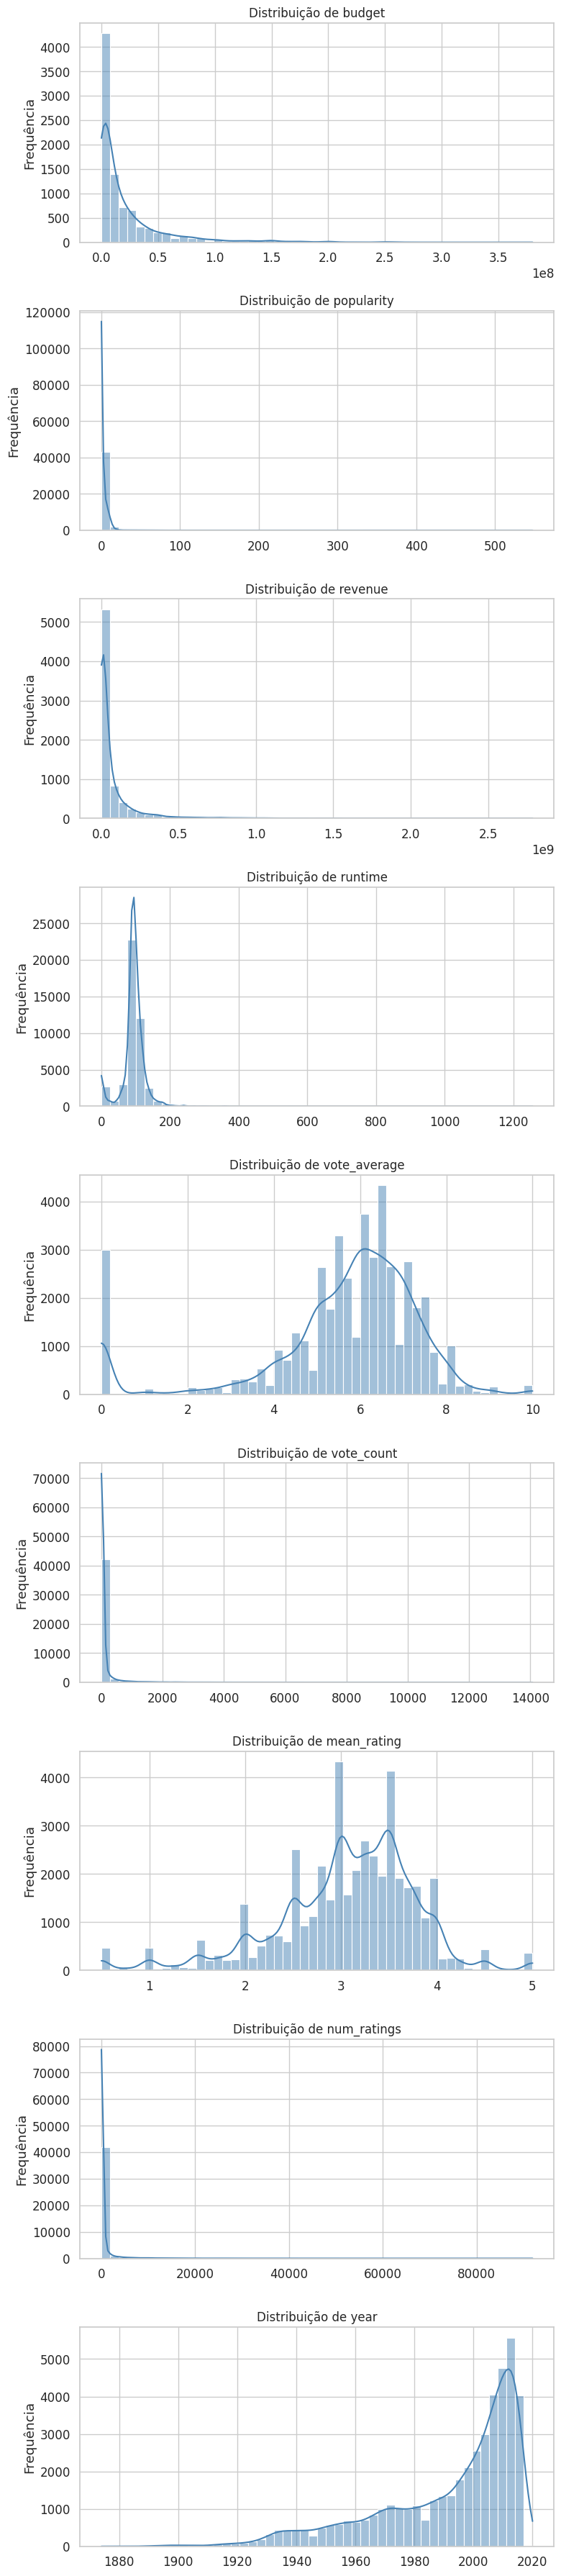

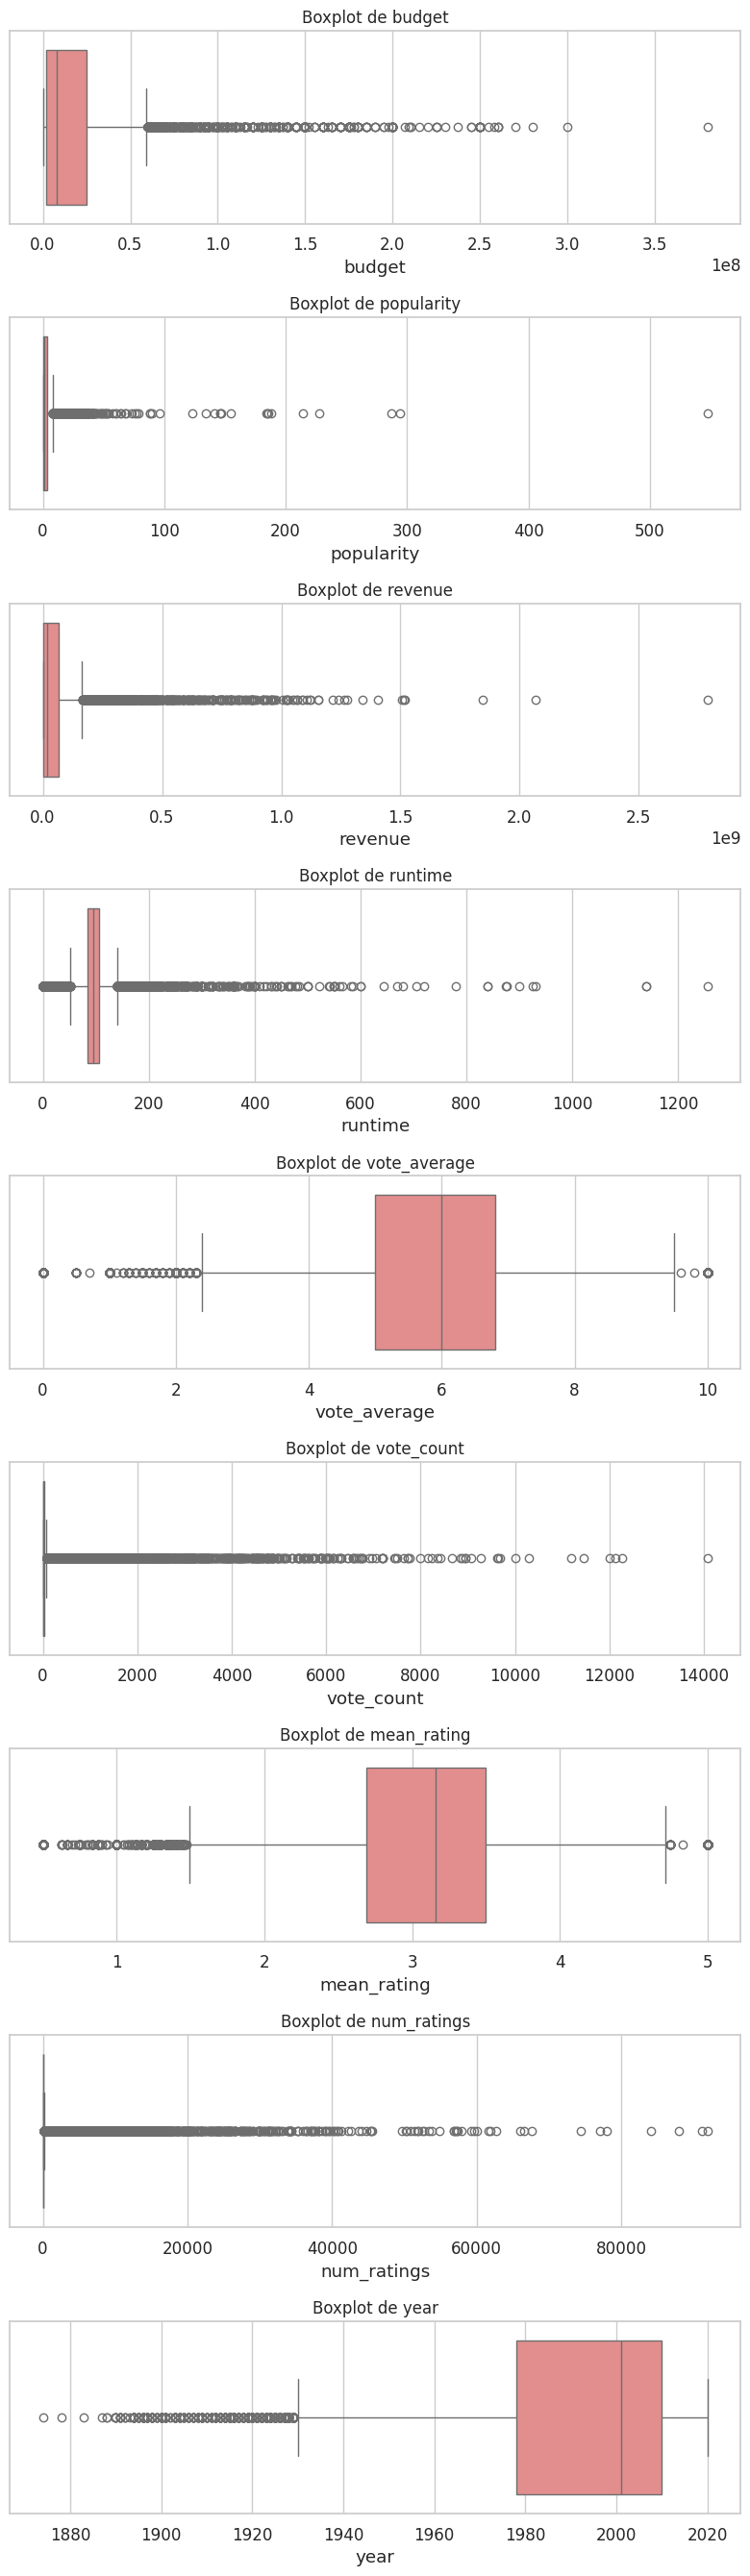

In [19]:
# Ploto Histogramas + KDEs
fig, axes = plt.subplots(nrows=len(num_attributes.columns), ncols=1, figsize=(8, 4*len(num_attributes.columns)))

for i, col in enumerate(num_attributes.columns):
    ax = axes[i] if len(num_attributes.columns) > 1 else axes
    sns.histplot(data=num_attributes, x=col, kde=True, bins=50, ax=ax, color="steelblue")
    ax.set_title(f"Distribuição de {col}", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Frequência")

plt.tight_layout()
plt.show()

# Ploto Boxplots (para ver outliers)
fig, axes = plt.subplots(nrows=len(num_attributes.columns), ncols=1, figsize=(8, 3*len(num_attributes.columns)))

for i, col in enumerate(num_attributes.columns):
    ax = axes[i] if len(num_attributes.columns) > 1 else axes
    sns.boxplot(data=num_attributes, x=col, ax=ax, color="lightcoral")
    ax.set_title(f"Boxplot de {col}", fontsize=12)

plt.tight_layout()
plt.show()

### K2 — 5.1.2 — Variáveis categóricas
* Tem algumas poucas linhas de imdb_id, overview e título repetidas. O que pode implicar duplicada ou até mesmo franquia de filmes.
* O resto faz sentido.

In [20]:
cat = df.select_dtypes(exclude=["float64","int64","Int64","datetime64[ns]"])

In [21]:
# Conto de valores únicos em cada categorias
cat.nunique(dropna=True).sort_values(ascending=False)

imdb_id                45393
overview               44284
original_title_norm    43264
star4                  25959
star3                  24487
star2                  22374
star1                  18364
director               17564
genres_list             4067
countries_names         2390
original_language         91
dtype: int64

In [22]:
# alguns tops 10 úteis para o negócio
def top_counts(col, k=10):
    return (df[col]
            .value_counts(dropna=True)
            .head(k)
            .rename_axis(col)
            .to_frame("count"))

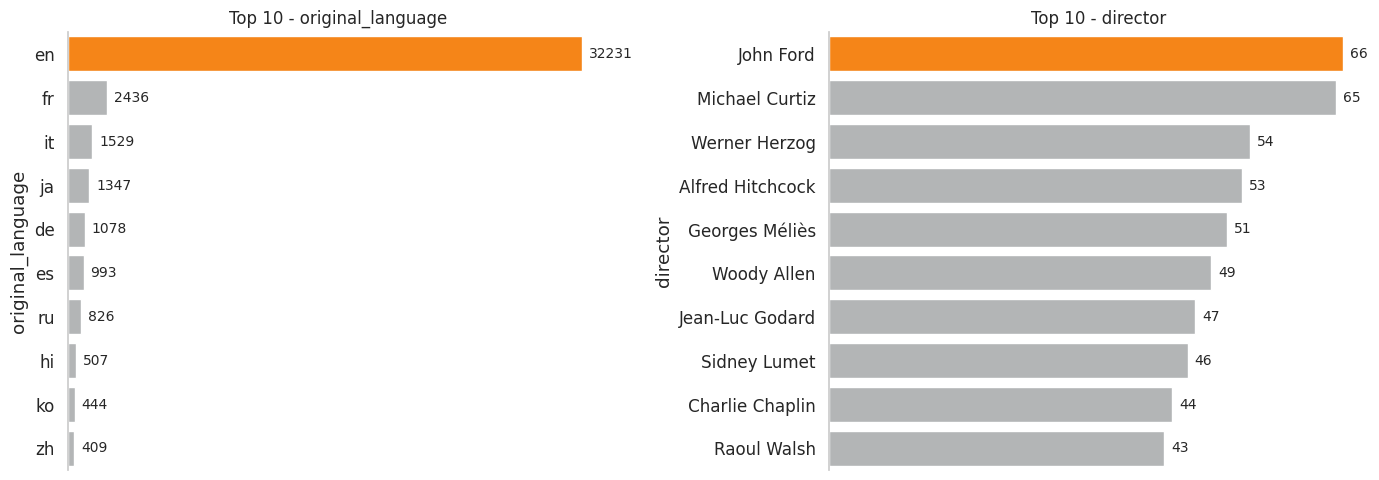

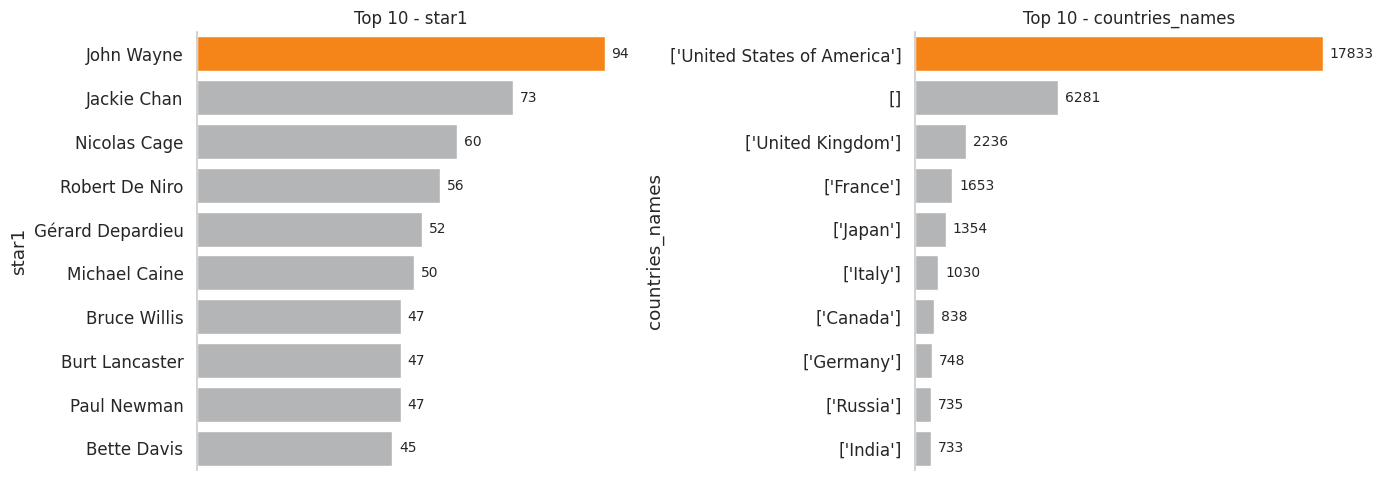

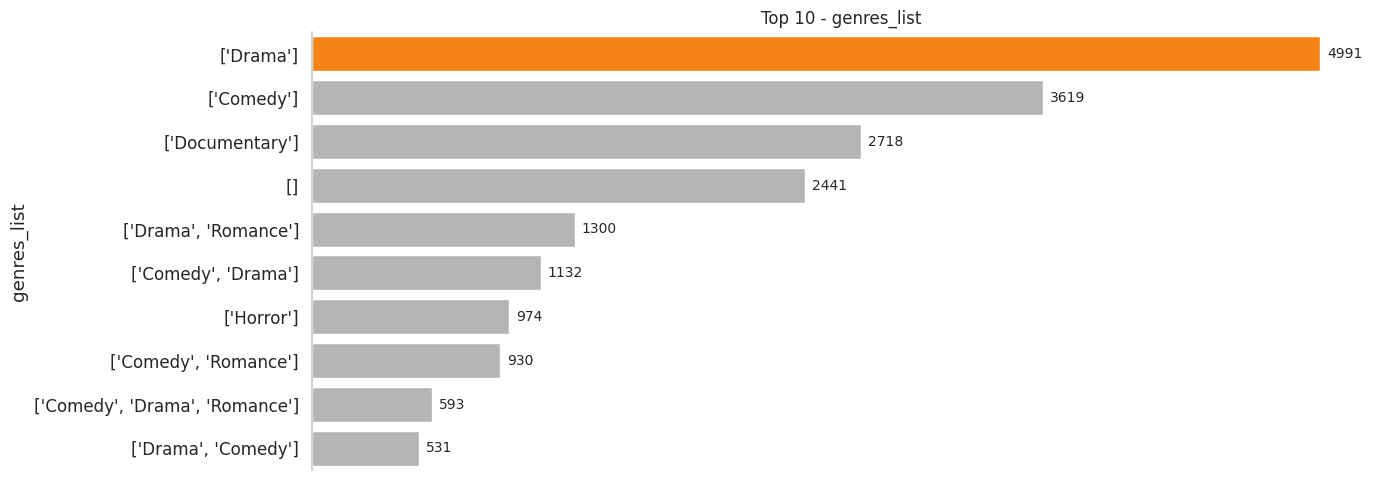

In [23]:
# Função auxiliar para pegar o Top N de qualquer variável categórica
def top_counts(col, n=10):
    return df[col].value_counts().head(n)

# Listas de variáveis categóricas que fazem sentido visualizar
cat_vars = ["original_language", "director", "star1", "countries_names", "genres_list"]

# Plotar 2 a 2, mantendo padrão visual
for i in range(0, len(cat_vars), 2):
    subset = cat_vars[i:i+2]
    fig, axes = plt.subplots(1, len(subset), figsize=(14, 5))

    if len(subset) == 1:  # caso tenha só 1 variável
        axes = [axes]

    for ax, col in zip(axes, subset):
        counts = top_counts(col)
        sns.barplot(x=counts.values.flatten(),
                    y=counts.index,
                    ax=ax,
                    color=NEUTRAL)

        # Retiro eixo X
        ax.xaxis.set_visible(False)

        # Destaco a primeira barra com cor diferente
        ax.patches[0].set_facecolor(HILIGHT)

        # Coloco os valores em cima de cada barra
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', padding=5, fontsize=10)

        # Retiro bordas extras
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax.set_title(f"Top 10 - {col}", fontsize=12)

    plt.tight_layout()
    plt.show()

## K2 — 5.2 — Análise Bivariada

In [24]:
tmp = df.copy()
tmp["budget"] = pd.to_numeric(tmp["budget"], errors="coerce")
tmp["revenue"] = pd.to_numeric(tmp["revenue"], errors="coerce")
tmp = tmp.dropna(subset=["budget","revenue"])
tmp = tmp[(tmp["budget"] > 0) & (tmp["revenue"] > 0)]

### K2 — 5.2.1 — Numéricas x Numéricas

In [25]:
# Identifico os 3 filmes com maior receita e criO uma nova coluna para colorir
tmp = tmp.sort_values(by="revenue", ascending=False).reset_index(drop=True)
top_movies = tmp.head(3)
tmp['destaque'] = tmp['original_title_norm'].apply(lambda x: x if x in top_movies['original_title_norm'].values else 'Outros Filmes')

fig = px.scatter(
    tmp, x="budget", y="revenue",
    labels={"budget":"Orçamento (USD)", "revenue":"Receita (USD)"},
    opacity=0.6,
    color="destaque", 
    color_discrete_map={
        top_movies.iloc[0]['original_title_norm']: HILIGHT,
        top_movies.iloc[1]['original_title_norm']: HILIGHT,
        top_movies.iloc[2]['original_title_norm']: HILIGHT,
        'Outros Filmes': NEUTRAL
    },
    title="Orçamento vs Receita (cada ponto = 1 filme)"
)

# Linha de referência y = x (break-even)
minv = float(min(tmp["budget"].min(), tmp["revenue"].min()))
maxv = float(max(tmp["budget"].max(), tmp["revenue"].max()))
fig.add_shape(type="line", x0=minv, y0=minv, x1=maxv, y1=maxv,
             line=dict(color=HILIGHT, width=2, dash="dash"))
fig.add_annotation(x=maxv, y=maxv, text="break-even (y = x)",
                   showarrow=False, font=dict(color=HILIGHT))

# Configurações do layout
fig.update_traces(hovertemplate="Orçamento: %{x:.0f}<br>Receita: %{y:.0f}<extra></extra>")
fig.update_layout(
    margin=dict(l=10,r=10,t=60,b=10),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.4,
    )
)
fig.show()

In [26]:
tmp = df[['original_title_norm','runtime','revenue']].copy()
tmp[['runtime','revenue']] = tmp[['runtime','revenue']].apply(pd.to_numeric, errors='coerce')
tmp = tmp.dropna()
# filtros leves para não esmagar o gráfico
tmp = tmp[(tmp['runtime']>0) & (tmp['runtime']<=400) & (tmp['revenue']>0)]

# destaca top-3 por receita
tmp = tmp.sort_values('revenue', ascending=False).reset_index(drop=True)
top_movies = tmp.head(3)
tmp['destaque'] = tmp['original_title_norm'].apply(
    lambda x: x if x in top_movies['original_title_norm'].values else 'Outros Filmes'
)

# correlação (Spearman)
rho = tmp[['runtime','revenue']].corr(method='spearman').iloc[0,1]

fig = px.scatter(
    tmp, x='runtime', y='revenue',
    labels={'runtime':'Duração (min)', 'revenue':'Receita (USD)'},
    opacity=0.6, color='destaque',
    color_discrete_map={
        top_movies.iloc[0]['original_title_norm']: HILIGHT,
        top_movies.iloc[1]['original_title_norm']: HILIGHT,
        top_movies.iloc[2]['original_title_norm']: HILIGHT,
        'Outros Filmes': NEUTRAL
    },
    title=f"Duração vs Receita (escala linear) — ρₛ = {rho:.2f}"
)

fig.update_traces(hovertemplate="Duração: %{x:.0f} min<br>Receita: %{y:.0f}<extra></extra>")
fig.update_layout(
    margin=dict(l=10,r=10,t=60,b=10),
    legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1.4)
)
fig.show()

In [27]:
tmp = df[['original_title_norm','vote_average','revenue']].copy()
tmp[['vote_average','revenue']] = tmp[['vote_average','revenue']].apply(pd.to_numeric, errors='coerce')
tmp = tmp.dropna()
tmp = tmp[(tmp['vote_average']>=0) & (tmp['vote_average']<=10) & (tmp['revenue']>0)]

# top-3 por receita
tmp = tmp.sort_values('revenue', ascending=False).reset_index(drop=True)
top_movies = tmp.head(3)
tmp['destaque'] = tmp['original_title_norm'].apply(
    lambda x: x if x in top_movies['original_title_norm'].values else 'Outros Filmes'
)

rho = tmp[['vote_average','revenue']].corr(method='spearman').iloc[0,1]

fig = px.scatter(
    tmp, x='vote_average', y='revenue',
    labels={'vote_average':'Nota média (0–10)', 'revenue':'Receita (USD)'},
    opacity=0.6, color='destaque',
    color_discrete_map={
        top_movies.iloc[0]['original_title_norm']: HILIGHT,
        top_movies.iloc[1]['original_title_norm']: HILIGHT,
        top_movies.iloc[2]['original_title_norm']: HILIGHT,
        'Outros Filmes': NEUTRAL
    },
    title=f"Nota média vs Receita (escala linear) — ρₛ = {rho:.2f}"
)

fig.update_traces(hovertemplate="Nota média: %{x:.2f}<br>Receita: %{y:.0f}<extra></extra>")
fig.update_layout(
    margin=dict(l=10,r=10,t=60,b=10),
    legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1.4)
)
fig.show()

In [28]:
tmp = df[['original_title_norm','vote_count','revenue']].copy()
tmp[['vote_count','revenue']] = tmp[['vote_count','revenue']].apply(pd.to_numeric, errors='coerce')
tmp = tmp.dropna()
tmp = tmp[(tmp['vote_count']>0) & (tmp['revenue']>0)]

# top-3 por receita
tmp = tmp.sort_values('revenue', ascending=False).reset_index(drop=True)
top_movies = tmp.head(3)
tmp['destaque'] = tmp['original_title_norm'].apply(
    lambda x: x if x in top_movies['original_title_norm'].values else 'Outros Filmes'
)

rho = tmp[['vote_count','revenue']].corr(method='spearman').iloc[0,1]

fig = px.scatter(
    tmp, x='vote_count', y='revenue',
    labels={'vote_count':'Contagem de votos', 'revenue':'Receita (USD)'},
    opacity=0.6, color='destaque',
    color_discrete_map={
        top_movies.iloc[0]['original_title_norm']: HILIGHT,
        top_movies.iloc[1]['original_title_norm']: HILIGHT,
        top_movies.iloc[2]['original_title_norm']: HILIGHT,
        'Outros Filmes': NEUTRAL
    },
    title=f"Votos vs Receita (escala linear) — ρₛ = {rho:.2f}"
)

fig.update_traces(hovertemplate="Votos: %{x:,}<br>Receita: %{y:.0f}<extra></extra>")
fig.update_layout(
    margin=dict(l=10,r=10,t=60,b=10),
    legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1.4)
)
fig.show()

### K2 — 5.2.2 — Categóricas x Numéricas

In [29]:
# Duração
runtime = pd.to_numeric(df["runtime"], errors="coerce").dropna()
if len(runtime) == 0:
    print("Sem valores válidos em 'runtime'.")
else:
    p99 = runtime.quantile(0.99)
    rt_cap = runtime.clip(upper=p99)
    med = rt_cap.median()

    # Histograma com plotly express (apenas para gerar as barras)
    fig = px.histogram(rt_cap, nbins=30, labels={"value": "Duração (min)", "count": "Número de filmes"})
    fig.update_traces(
        marker_color=NEUTRAL,
        texttemplate="%{y}",
        textposition="outside",
        hovertemplate="Minutos: %{x}<br># filmes: %{y}<extra></extra>"
    )

    # Eixos limpos (sem eixo Y)
    fig.update_yaxes(visible=False)
    fig.update_xaxes(title="Duração (min)")

    # Linha e anotação da mediana
    fig.add_vline(x=med, line_width=2, line_dash="dash", line_color=HILIGHT)
    fig.add_annotation(
        x=med, y=1.02, xref="x", yref="paper",
        text=f"mediana ≈ {med:.0f} min",
        showarrow=True, font=dict(color=HILIGHT), height=20,
    )

    # Layout compacto
    fig.update_layout(
        title="Duração dos filmes",
        showlegend=False,
        bargap=0.02,
        margin=dict(l=10, r=10, t=60, b=10)
    )

    fig.show()

In [30]:
# Em milhões
budget_m = pd.to_numeric(df["budget"], errors="coerce").replace(0, np.nan).dropna() / 1e6
if len(budget_m) == 0:
    print("Sem valores válidos em 'budget'.")
else:
    # reduzi a distorção de poucos blockbusters
    p99 = budget_m.quantile(0.99)
    bcap = budget_m.clip(upper=p99)
    med  = float(bcap.median())

    fig = px.histogram(
        bcap, nbins=40,
        labels={"value": "Orçamento (US$ milhões)", "count": "Nº de filmes"},
        title="Orçamento por filmes"
    )
    # barras neutras
    fig.update_traces(marker_color=NEUTRAL, hovertemplate="Orçamento: %{x:.0f} mi<br>Nº Filmes: %{y}<extra></extra>")
    fig.update_yaxes(showticklabels=True, title="Nº de Filmes")
    fig.update_xaxes(title="Orçamento (US$ milhões)")

    # mediana destacada
    fig.add_vline(x=med, line_width=2, line_dash="dash", line_color=HILIGHT)
    fig.add_annotation(
        x=med, y=1.02, xref="x", yref="paper",
        text=f"mediana ≈ {med:.0f} mi", showarrow=False, 
        font=dict(color=HILIGHT)
    )

    fig.update_layout(showlegend=False, bargap=0.02, margin=dict(l=10, r=10, t=60, b=10))
    fig.show()

In [31]:
# Lançamento por de décadas
dec = (pd.to_numeric(df["year"], errors="coerce")
       .dropna().astype(int) // 10 * 10)
ct = dec.value_counts().sort_index()
dec_df = pd.DataFrame({"decade": ct.index.astype(int), "films": ct.values})

# Identifico a década com maior número de filmes
imax = dec_df["films"].idxmax()
dec_df["color"] = NEUTRAL
dec_df.loc[imax, "color"] = HILIGHT

# Ploto
fig = px.bar(dec_df, x="decade", y="films",
             text="films",
             labels={"decade":"", "films":"Número de filmes"},
             color="color", color_discrete_map="identity",
             title="Lançamentos de filmes por década")

# Layout compacto
fig.update_layout(
        showlegend=False,
        bargap=0.02,
        margin=dict(l=10, r=10, t=60, b=10)
    )

# Removo eixo Y para uma visualização mais limpa
fig.update_yaxes(showticklabels=False, title=None)

# Coloco os valores fora da barra
fig.update_traces(textposition="outside")

fig.show()

In [32]:
# Em milhões
revenue_m = pd.to_numeric(df["revenue"], errors="coerce").replace(0, np.nan).dropna() / 1e6
if len(revenue_m) == 0:
    print("Sem valores válidos em 'revenue'.")
else:
    # reduzi a distorção de poucos blockbusters
    p99 = revenue_m.quantile(0.99)
    bcap = revenue_m.clip(upper=p99)
    med  = float(bcap.median())

    fig = px.histogram(
        bcap, nbins=40,
        labels={"value": "Receita em (US$ milhões)", "count": "Nº de filmes"},
        title="Receita por filmes"
    )
    # barras neutras
    fig.update_traces(marker_color=NEUTRAL, hovertemplate="Receita: %{x:.0f} mi<br> Nº Filmes: %{y}<extra></extra>")
    fig.update_yaxes(showticklabels=True, title="Nº de Filmes")
    fig.update_xaxes(title="Receita (US$ milhões)")

    # mediana destacada
    fig.add_vline(x=med, line_width=2, line_dash="dash", line_color=HILIGHT)
    fig.add_annotation(
        x=med, y=1.02, xref="x", yref="paper",
        text=f"mediana ≈ {med:.0f} mi", showarrow=False, 
        font=dict(color=HILIGHT)
    )

    fig.update_layout(showlegend=False, bargap=0.02, margin=dict(l=10, r=10, t=60, b=10))
    fig.show()

In [33]:
# Preparo os dados
va = pd.to_numeric(df["vote_average"], errors="coerce").dropna()
med = va.median()

# Crie o histograma (inicialmente sem personalizações)
fig = px.histogram(
    va, nbins=20,
    labels={"value": "Nota IMDb", "count": "Nº de filmes"},
    color_discrete_sequence=[NEUTRAL],
    title="Notas (IMDb) por Filmes"
)

# Atualizo os 'traces' para incluir os números nas barras
fig.update_traces(
    marker_color=NEUTRAL,
    texttemplate="%{y}",
    textposition="outside",
    hovertemplate="Nota: %{x}<br>Nº filmes: %{y}<extra></extra>"
)

# Adiciono a linha e a anotação da mediana
fig.add_vline(x=med, line_width=2, line_dash="dash", line_color=HILIGHT)
fig.add_annotation(x=med, y=1.02, xref="x", yref="paper",
                   text=f"mediana ≈ {med:.1f}", showarrow=True,
                   font=dict(color=HILIGHT))

# Atualizo o layout para remover o eixo Y
fig.update_layout(
    xaxis_title="Nota IMDb",
    yaxis_visible=False,
    yaxis_showticklabels=False,
    showlegend=False,
    margin=dict(l=10, r=10, t=60, b=10),
    xaxis=dict(
        tickvals=list(range(0, 11)), 
        tickmode='array'
    )
)

fig.show()

In [34]:
vc = pd.to_numeric(df["vote_count"], errors="coerce").dropna()
if len(vc):
    p99 = vc.quantile(0.99)
    vc_cap = vc.clip(upper=p99)
    med = vc_cap.median()

    fig = px.histogram(
        vc_cap, nbins=40,
        labels={"value": "Nº de votos", "count": "Nº de filmes"},
        color_discrete_sequence=[NEUTRAL],
        title="Contagem de votos por filme"
    )

    # Números nas barras + hover limpo
    fig.update_traces(
        marker_color=NEUTRAL,
        texttemplate="%{y}",
        textposition="outside",
        hovertemplate="Votos: %{x:.0f}<br>Nº filmes: %{y}<extra></extra>"
    )

    # Linha + anotação da mediana
    fig.add_vline(x=med, line_width=2, line_dash="dash", line_color=HILIGHT)
    fig.add_annotation(
        x=med, y=1.02, xref="x", yref="paper",
        font=dict(color=HILIGHT)
    )

    # Remove eixo Y; 
    fig.update_layout(
        xaxis_title="Nº de votos",
        yaxis_visible=False, yaxis_showticklabels=False,
        showlegend=False,
        margin=dict(l=10, r=10, t=60, b=10)
    )

    fig.show()
else:
    print("Sem valores válidos em 'vote_count'.")


## K2 — 5.3 — Análise Multivariada 

### K2 — 5.3.1 — Atributos numéricos

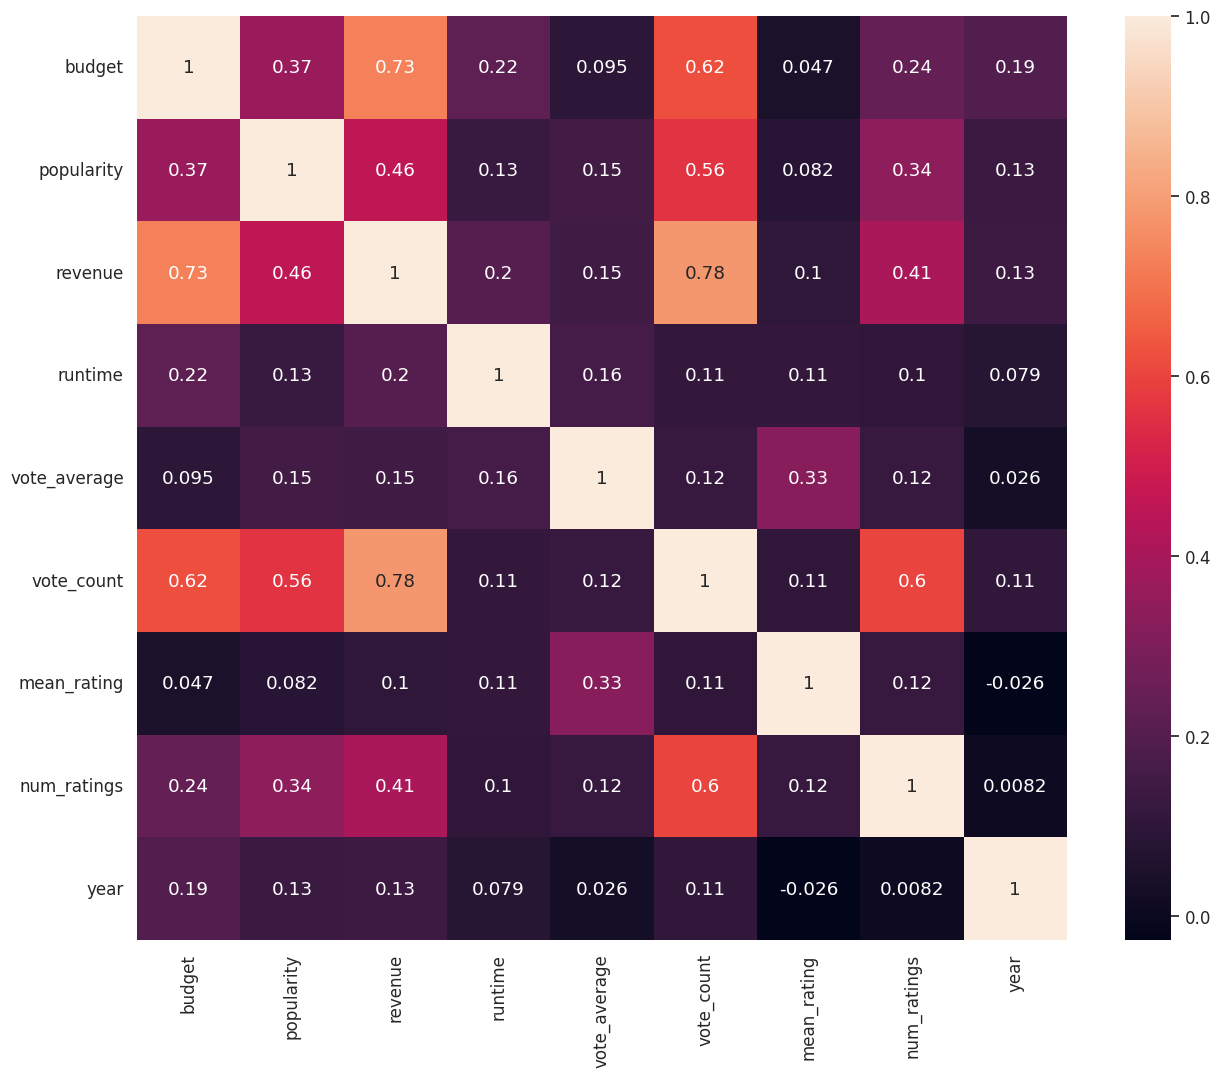

In [35]:
# Calculate the correlation matrix using Pearson correlation method for numeric attributes.
correlation = num_attributes.corr(method='pearson')
# Set the figure size
plt.figure(figsize=(15, 12))
# Plot the heatmap
sns.heatmap(correlation, annot=True)
# Display the heatmap
plt.show()

### K2 — 5.3.2 — Atributos categóricos

In [36]:
# # Seleciono as colunas categóricas para a análise
# colunas_analise = ['director', 'star1', 'star2', 'star3','star4','genres_list', 'countries_names', 'original_language', 'overview']
# df_cat = df[colunas_analise].dropna()

# # Crio a matriz de Cramer's V
# matriz_cramer = pd.DataFrame(index=colunas_analise, columns=colunas_analise)

# for col1 in colunas_analise:
#     for col2 in colunas_analise:
#         if col1 == col2:
#             matriz_cramer.loc[col1, col2] = 1.0
#         else:
#             v_score = cramer_v(df_cat[col1], df_cat[col2])
#             matriz_cramer.loc[col1, col2] = v_score

# # Converto para tipo float para o heatmap
# matriz_cramer = matriz_cramer.astype(float)

# # Crio o heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(matriz_cramer, annot=True, cmap='viridis', fmt=".2f",
#             linewidths=.5)
# plt.title("Matriz de Associação (Cramer's V) entre Variáveis Categóricas")
# plt.show()

### K2 — 5.3.3 — Scatterplots coloridos por terceira variável

In [37]:
tmp = df[['budget','revenue','vote_average']].copy()
tmp = tmp.apply(pd.to_numeric, errors='coerce').dropna()
tmp = tmp[(tmp['budget']>0) & (tmp['revenue']>0)]

fig = px.scatter(
    tmp, x='budget', y='revenue',
    color='vote_average',  # terceira variável
    color_continuous_scale='Viridis',
    opacity=0.6,
    labels={'budget':'Orçamento (USD)','revenue':'Receita (USD)','vote_average':'Nota Média'},
    title="Orçamento vs Receita (cor = Nota Média)"
)

# Linha de referência y = x (break-even)
minv = float(min(tmp["budget"].min(), tmp["revenue"].min()))
maxv = float(max(tmp["budget"].max(), tmp["revenue"].max()))
fig.add_shape(type="line", x0=minv, y0=minv, x1=maxv, y1=maxv,
             line=dict(color="red", width=2, dash="dash"))

fig.update_traces(hovertemplate="Orçamento: %{x:.0f}<br>Receita: %{y:.0f}<br>Nota média: %{marker.color:.2f}<extra></extra>")
fig.update_layout(margin=dict(l=10,r=10,t=60,b=10))
fig.show()

## K2 — 5.4 — Insights Parciais

**Insights:**
- **Budget**:
    * Média: aproximadamente 21,6 milhões de dólares.
    * Mediana: 8,0 milhões. Metade dos filmes que informam orçamento, gastam até 8,0 milhões.
    * Insight: muitos filmes não reportam orçamento (NaN), mas quando há dado, a distribuição é extremamente enviesada (skew 3.1): poucos blockbusters com centenas de milhões puxam a média para cima.

- **Revenue**:
    * Metade dos filmes que reportam, possuem faturamento menor do que 20 milhões (~16,8).
    * Insight: Alguns filmes chegam a bilhões (máx. ~2,7B), puxando a média (~68M). Skew alto (5.1) mostra que a maioria tem faturamento bem abaixo dos outliers.

- **Runtime**:
    * Mediana de aproximadamente 95 minutos, consistente com filmes comerciais.
    * Insight: Outliers extremos (ex.: > 400 min ou 1256 min) provavelmente são erros de cadastro. Devemos considerar filtrar esses casos em análises/modelos.

- **Vote_average**:
    * Mediana = 6.0, média = 5.6. Distribuição está ligeiramente enviesada à esquerda.
    * Coluna cujos os valores fazem sentidos, muitas notas medianas, poucas notas extremas.
    * Tendência leve de avaliações concentradas em notas mais altas

- **Vote_count / Num_ratings**:
    * Mediana muito baixa (10 votos ou 8 ratings), enquanto a média é puxada por alguns filmes muito populares. Ou seja, média de votos é ~110, mas a maioria dos filmes tem pouquíssimos votos e, a skew alta (10–12), confirmaa que só alguns filmes atraem massa de avaliadores.
    * Insight: precisaremos filtrar por mínimo de votos para não analisar filmes obscuros. Assim, para evitar ruído análises que relacionam notas ou faturamento com votos devem considerar limite mínimo de votos (ex.: ≥ 100).
    * Insight2: a partir dos anos 2000 houve expansão da indústria, globalização do mercado e popularização de plataformas de rating online (IMDb, Rotten Tomatoes, etc.), o que aumenta o número de votos. Existe o risco de inflacionar métricas (popularidade, número de votos, nota média) nos filmes mais recentes, simplesmente porque são mais acessíveis ao público conectado.
    * Insight3: pode ser necessário testar hipóteses temporais, por exemplo: "filmes lançados após 2000 tendem a ter mais votos?". Ajustar análises e modelagem para tempo (ex.: incluir "ano" como controle ou trabalhar com janelas temporais [filmes 2000+], principalmente hipóteses nas hipóteses que envolvem popularidade e receita). 

- **Mean_rating (média das avaliações)**:
    * Distribuição relativamente normal, centrada em aproximadamente 3.1.
    * Faz sentido, é a escala do dataset, levemente enviesada para baixo (skew -0,84).

- **Year**:
    * Faixa: Min = 1874, Max = 2020. Há registros de filmes muito antigos (antes do cinema comercial consolidado) e alguns bem recentes.
    * Mediana = 2001. Mostra que a base é bem centrada em lançamentos mais recentes.
    * Faz sentido termos mais lançamentos recentes devido a popularição dos filmes e a concorrência crescente que se insentificou a partir dos anos 2000.
    * Insight: testar a hipótese de que o aumento dos votos ao longo do tempo inflaciona métricas de popularidade e IMDb. Ajustes temporias podem ser necessários em modelos (fazer um corte e pegar a partir dos anos 2000 pode ser uma solução).

# K2 — 6.0 — Hipóteses de Negócio

- H1. Quanto maior o orçamento mais receita o filme gera?
- H2. Popularidade do filme antecipa sucesso de bilheteria (receita)?
- H3. Quanto maior a nota da crítica maior a receita?
- H4. Filmes muito longos penalizam a nota?
- H5. Gêneros específicos têm maior probabilidade de retorno?
- H6. Existe associação entre diretor/elenco e sucesso de bilheteria (receita)? Essa influência permanece quando controlamos por ROI?
- H7. Qual filme recomendaria a alguém que você não conhece?
- H8. Ano de lançamento dos filmes influencia no sucesso (receita)?
- H9. Overview ajuda a inferir gênero? Quais insights podem ser tirados dela? (**modelo de classificação por NLP**)
- H10. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? (**modelo de regressão linear**)
- H11. Previsão de Nota IMDb para dois título específicos (**modelo de regressão**)
- H12. Lançamentos no verão tendem a arrecadar mais? (**próximo ciclo do projeto**)

## K2 — 6.1 — H1. Quanto maior o orçamento mais receita o filme gera?
R: Sim, gastar mais dinheiro em um filme aumenta a probabilidade de gerar mais receita, mas não garante que ele será considerado um sucesso de crítica (nota alta).

**Insights - ROI:**
* Quanto maior o orçamento (investimento em produção e marketing), maior a probabilidade de arrecadar mais. 
* Metade dos filmes retornou pelo menos o dobro do orçamento (Mediana ~2).
* 25% dos fillmes tiveram ROI menor ou igual a 1,00, ou seja, atingiram o break-even ou tiveram prejuízo.
* A média é puxada para cima por outliers, onde 25% dos filmes conseguiram mais de 4x o investimento.
  
**Insights - de Negócio:**
* Filmes "médios" (não tão caros) podem ter ROI melhor que os blockbusters.
* Nem sempre o sucesso comercial (receita) do filme quer dizer sucesso crítico também. 
* Popularidade (popularity e vote_count) pode ser usada como proxy inicial de interesse público.

**Conclusão:** Projetos médios podem ter ROI excelente (mais “eficiência de capital”). Para avaliar retorno, priorize ROI mediano por faixa de orçamento e use popularidade como sinal precoce de demanda - sem confundir com qualidade.

In [38]:
temp_df = df.copy()

# Converte as colunas para numéricas
for col in ["budget", "revenue", "vote_average", "vote_count", "popularity"]:
    temp_df[col] = pd.to_numeric(temp_df[col], errors="coerce")

# Remove nulos
temp_df = temp_df.dropna(subset=["budget", "revenue", "vote_average", "vote_count", "popularity"])

# Filtros básicos
temp_df = temp_df[
    (temp_df["budget"] >= 1000) & 
    (temp_df["revenue"] > 1) & (temp_df["revenue"] <= temp_df["revenue"].quantile(0.995)) &
    (temp_df["vote_count"] > 50)
]

# Filtro popularidade no percentil 99
pop_cap = temp_df["popularity"].quantile(0.99)
temp_df = temp_df[temp_df["popularity"] <= pop_cap]

# Conversão para milhões
temp_df["budget_milhoes"]  = temp_df["budget"]  / 1_000_000
temp_df["revenue_milhoes"] = temp_df["revenue"] / 1_000_000

In [39]:
temp_df['log_budget']  = np.log(temp_df['budget'])
temp_df['log_revenue'] = np.log(temp_df['revenue'])

In [40]:
# Calcular a matriz de correlação de Spearman
# O método 'spearman' garante a robustez aos outliers
correlacao_spearman = temp_df[['budget', 'revenue', 'vote_average', 'popularity', 'vote_count']].corr(method='spearman')
correlacao_spearman

budget  revenue  vote_average  popularity  vote_count
budget          1.00     0.66         -0.22        0.32        0.45
revenue         0.66     1.00          0.04        0.43        0.68
vote_average   -0.22     0.04          1.00        0.19        0.28
popularity      0.32     0.43          0.19        1.00        0.61
vote_count      0.45     0.68          0.28        0.61        1.00

In [41]:
# ROI simples
temp_df["roi"] = temp_df["revenue"]/temp_df["budget"]

# # resumo de ROI
temp_df["roi"].describe(percentiles=[.25,.5,.75])

count    4272.00
mean        9.72
std       208.44
min         0.00
25%         0.98
50%         2.26
75%         4.40
max     12890.39
Name: roi, dtype: float64

In [42]:
# Top 10 filmes em ROI
top_10_roi = temp_df.sort_values(by='roi', ascending=False).head(10)
top_10_roi[['original_title_norm', 'budget', 'revenue', 'roi']]

original_title_norm    budget      revenue      roi
834            paranormal activity  15000.00 193355800.00 12890.39
1026       the blair witch project  60000.00 248000000.00  4133.33
2055                    eraserhead  10000.00   7000000.00   700.00
3561                          猛龍過江 130000.00  85000000.00   653.85
5633                pink flamingos  12000.00   6000000.00   500.00
1985                 super size me  65000.00  28575078.00   439.62
2590                   the gallows 100000.00  42664410.00   426.64
2907                    open water 130000.00  54667954.00   420.52
1725  the texas chain saw massacre  85000.00  30859000.00   363.05
773                          bambi 858000.00 267447150.00   311.71

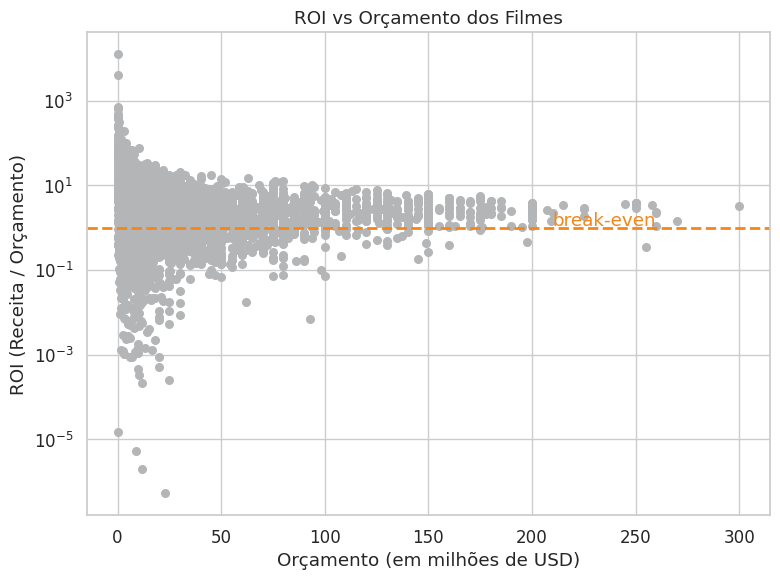

In [43]:
# ROI vs Orçamento
plt.figure(figsize=(8,6))
plt.scatter(temp_df["budget_milhoes"], temp_df["roi"], alpha=1, s=30, color=NEUTRAL)
plt.yscale("log")
plt.xlabel("Orçamento (em milhões de USD)")
plt.ylabel("ROI (Receita / Orçamento)")
plt.title("ROI vs Orçamento dos Filmes")

# linha ROI=1 (break-even)
plt.axhline(1, color=HILIGHT, linestyle="--", lw=2)
plt.text(temp_df["budget_milhoes"].max()*0.7, 1.1, "break-even", color=HILIGHT)

plt.tight_layout()
plt.show()

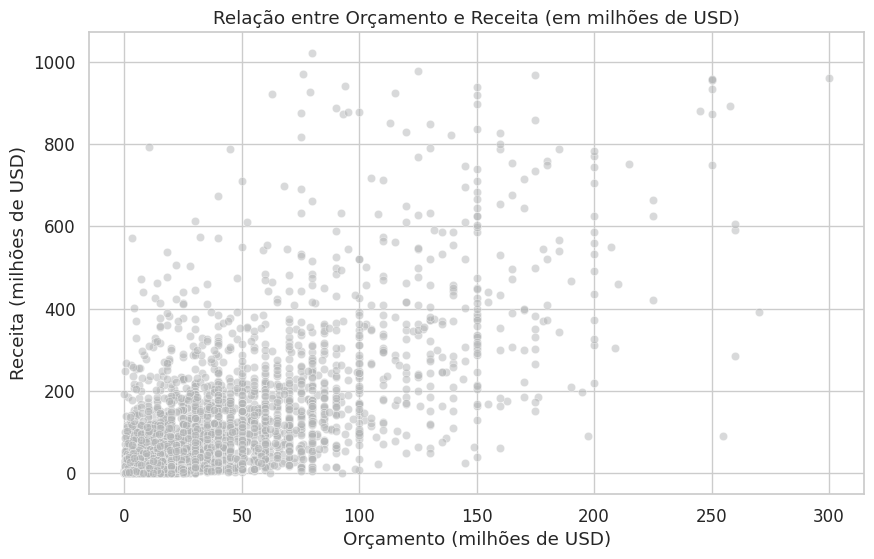

In [44]:
# Gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=temp_df, x='budget_milhoes', y='revenue_milhoes', alpha=0.5, color=NEUTRAL)
plt.title('Relação entre Orçamento e Receita (em milhões de USD)')
plt.xlabel('Orçamento (milhões de USD)')
plt.ylabel('Receita (milhões de USD)')
plt.grid(True)
plt.show()

## K2 — 6.2 — H2. Popularidade do filme antecipa sucesso de bilheteria (receita)?
R: Sim, em boa parte popularidade antecipa o sucesso financeiro. No entanto, ela não antecipa o sucesso de crítica. O fato de um filme ser muito comentado e buscado não significa que ele será bem avaliado pela crítica.

**Insights - Popularidade:**
* Conforme vimos no item acima há alguma correlação positiva entre o filme ser popular e ter receita maior.

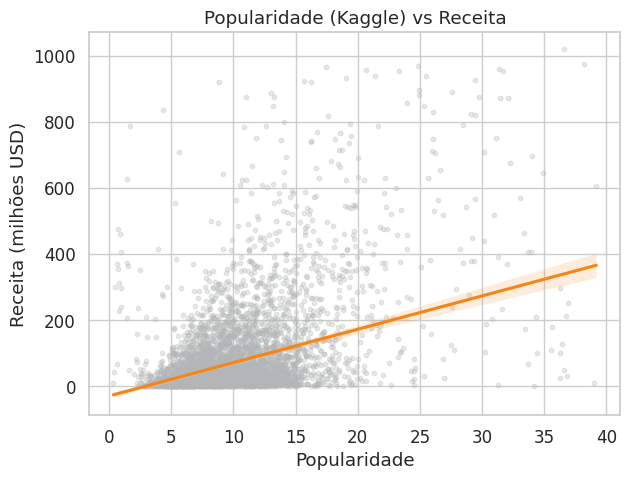

In [45]:
fig, ax = plt.subplots(figsize=(6.5,5))
sns.regplot(
    data=temp_df, x="popularity", y="revenue_milhoes",
    scatter_kws=dict(s=10, alpha=0.3, color=NEUTRAL),
    line_kws=dict(color=HILIGHT)
, ax=ax, robust=True)
ax.set_title("Popularidade (Kaggle) vs Receita")
ax.set_xlabel("Popularidade")
ax.set_ylabel("Receita (milhões USD)")
plt.tight_layout(); plt.show()

## K2 — 6.3 — H3. Quanto maior a nota da crítica (IMDb) maior a receita?
R: Não, o fato de o filme ser bem avaliado pela crítica também não significa que ele terá sucesso em termos de bilheteria (receita).

**Insights - Nota:**
* Gastar mais, não melhora a avaliação crítica. Grandes produções podem agradar a bilheteria (receita) e ser popular, mas não garantem nota alta no IMDb (crítica). 

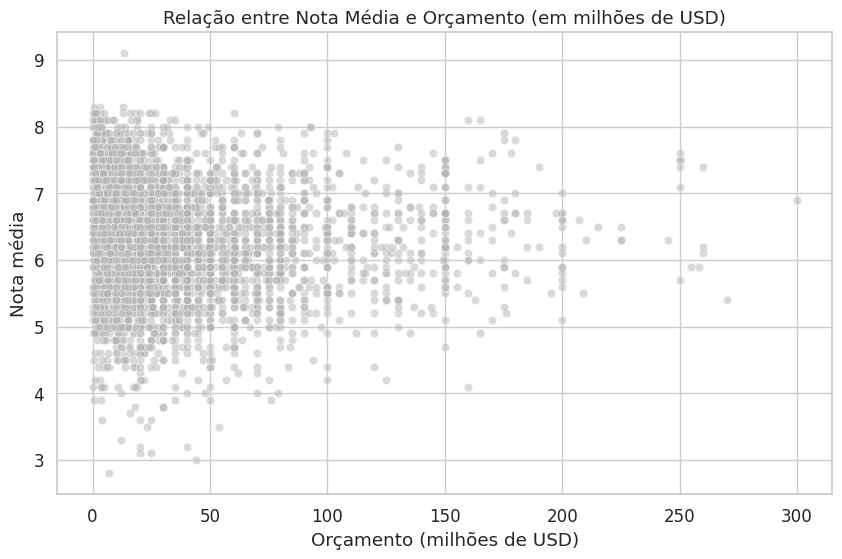

In [46]:
# Gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=temp_df, x='budget_milhoes', y='vote_average', alpha=0.5, color=NEUTRAL)
plt.title('Relação entre Nota Média e Orçamento (em milhões de USD)')
plt.xlabel('Orçamento (milhões de USD)')
plt.ylabel('Nota média')
plt.grid(True)
plt.show()

## K2 — 6.4 — H4. Filmes muito longos penalizam a nota?
R: Filmes mais longos não têm correlação negativa com avaliações. Pelo contrário, encontramos uma correlação fraca positiva (ρ = 0.16): em média, filmes mais longos recebem notas um pouco mais altas, mas o efeito é pequeno e não suficiente para ser considerado determinante.
O intervalo de conforto varia entre 90 a 130 minutos (maior densidade)

In [47]:
temp_df = df.copy()

# Converte as colunas para numéricas
for col in ["runtime", "mean_rating"]:
    temp_df[col] = pd.to_numeric(temp_df[col], errors="coerce")

# Remove nulos
temp_df = temp_df.dropna(subset=["runtime", "mean_rating"])

# Filtros básicos
temp_df = temp_df[
    (temp_df["runtime"] <= 800)
]

In [48]:
# Calcular a matriz de correlação de Spearman
# O método 'spearman' garante a robustez aos outliers
correlacao_spearman = temp_df[['mean_rating', 'runtime']].corr(method='spearman')
correlacao_spearman

mean_rating  runtime
mean_rating         1.00     0.16
runtime             0.16     1.00

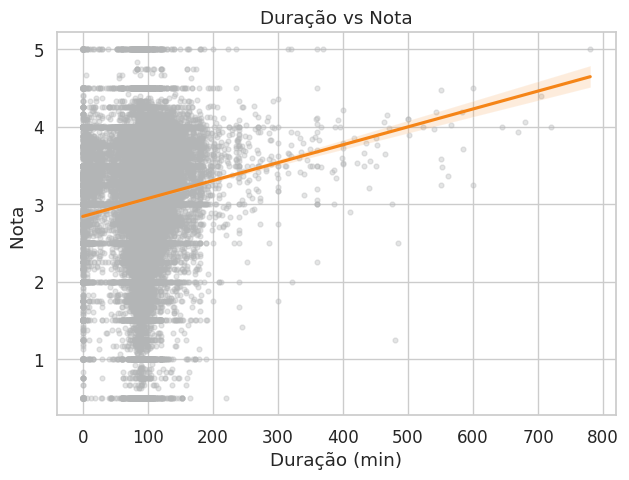

In [49]:
fig, ax = plt.subplots(figsize=(6.5,5))
sns.regplot(
    data=temp_df, x="runtime", y="mean_rating",
    scatter_kws=dict(s=12, alpha=0.35, color=NEUTRAL),
    line_kws=dict(color=HILIGHT)
, ax=ax)
ax.set_title("Duração vs Nota")
ax.set_xlabel("Duração (min)")
ax.set_ylabel("Nota ")
plt.tight_layout(); plt.show()

## K2 — 6.5 — H5. Gêneros específicos têm maior probabilidade de retorno?
R: Sim. Ao analisar as medianas, percebemos que gêneros como Animation, Family e Adventure mantêm receitas absolutas altas e consistentes, mas com ROI moderado devido aos orçamentos elevados. Já gêneros como Horror (fora do top 10 em receita, mas forte em ROI) e Music/Documentary apresentam retorno proporcional interessante, pois exigem menos investimento. Assim, blockbusters familiares lideram em bilheteria, enquanto gêneros de menor custo continuam relevantes pelo ROI.

**Principais Insights:**
  
**Receita (mediana) por Gênero:**
* Animation, Adventure, Fantasy e Family dominam em receita média (200M+ USD) e mediana (120M USD).
* São gêneros de alto orçamento e apelo global. Grandes bilheterias, mas custo também muito alto.
* Gêneros menores (Foreign, Western, TV Movie) apresentam receitas médias baixas.
* Comedy e Crime aparecem no top 10, mas com receitas medianas bem menores (~30M).
* Insight: blockbusters familiares (animações) dominam em volume de receita, mas não necessariamente em retorno financeiro. Se o foco é em receita, deve-se escolher ele.

**ROI (mediana) por Gênero:**
* Animation (2.77x), Horror (2.49x) e Family (2.48x) aparecem como destaques.
* O ROI de Horror cai bastante em relação à média, mostrando que poucos sucessos extremos puxa o valor para cima.
* Documentary e History também apresentam ROI alto em alguns casos, puxados por custos baixos.
* Gêneros de apelo amplo (Adventure, Fantasy, Comedy) mantêm ROI estável na faixa de 2x.
* Insight: gêneros de baixo custo (Horror, Mistery, Crime) são os campeões de rentabilidade relativa. **Mas quando olhamos a mediana, os gêneros “seguros” (Animation/Family) se mostram mais consistentes do que os de risco (Horror)**.

**Nota (mediana) por Gênero:**
* Diferenças pequenas (entre 5.9 e 6.9).
* History, War e Documentary lideram, com medianas acima de 6.8.
* Comedy, Horror e Foreign ficam nas menores notas (~5.9–6.3), refletindo volume grande e qualidade variada.
* Insight: crítica valoriza mais gêneros densos/históricos, enquanto populares sofrem com dispersão na qualidade.

**Conclusões de Negócio:**
* Receita - Se o objetivo é maximizar bilheteria, deve-se investir em Animation, Family e Adventure.
* ROI - Se o objetivo é retorno proporcional (ROI), ainda são os blockbusters que lideram, mas gêneros narrativos de baixo/médio custo (Horror, Crime, Mystery) se destacam pelo equilíbrio entre retorno e avaliação crítica.
* Se o objetivo é prestígio/crítica, deve-se priorizar Animation (qualidade técnica) ou Crime/Mystery.

**Para a PProductions, a recomendação inicial seria apostar em Animation/Family/Adventure para sustentar bilheteira, mas balancear com pelo menos um título em Crime ou Mystery para diversificação e maior reconhecimento crítico**

In [50]:
temp_df = df[['genres_list','revenue','budget','vote_average']].copy()

# Converto a string de lista na coluna 'genres_list' para uma lista Python real
temp_df['genres_list'] = temp_df['genres_list'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

for c in ['revenue','budget','vote_average']:
    temp_df[c] = pd.to_numeric(temp_df[c], errors='coerce')

# Filtros
temp_df = temp_df.dropna(subset=['budget','revenue','vote_average'])
temp_df = temp_df[(temp_df['budget'] >= 1_000) & (temp_df['revenue'] > 1)]

temp_df['revenue_milhoes'] = temp_df['revenue'] / 1_000_000
temp_df['roi'] = temp_df['revenue'] / temp_df['budget']

exploded = temp_df.explode('genres_list').dropna(subset=['genres_list'])

# cap no p99 para reduzir influência de outliers
p99_rev = exploded['revenue_milhoes'].quantile(0.99)
p99_roi = exploded['roi'].quantile(0.99)
exploded['rev_cap'] = exploded['revenue_milhoes'].clip(upper=p99_rev)
exploded['roi_cap'] = exploded['roi'].clip(upper=p99_roi)

# exige amostra mínima
counts = exploded['genres_list'].value_counts()
valid_genres = counts[counts >= 50].index # evita conclusões com poucos casos
g = exploded[exploded['genres_list'].isin(valid_genres)]

In [51]:
genre_stats = g.groupby('genres_list').agg(
    med_revenue=('rev_cap','median'),
    mean_revenue=('rev_cap','mean'),
    med_roi=('roi_cap','median'),
    mean_roi=('roi_cap','mean'),
    med_vote=('vote_average','median'),
    mean_vote=('vote_average','mean'),
    n=('rev_cap','size')
).reset_index()

In [52]:
genre_stats.sort_values(by='med_revenue', ascending=False).head(10)

genres_list  med_revenue  mean_revenue  med_roi  mean_roi  med_vote  \
2         Animation       120.45        221.13     2.77      5.15      6.60   
7            Family        95.40        191.58     2.48      4.48      6.20   
1         Adventure        86.72        196.46     2.29      4.15      6.20   
8           Fantasy        86.02        189.53     2.14      4.05      6.20   
0            Action        55.01        133.92     2.02      3.42      6.10   
14  Science Fiction        50.32        143.03     2.01      3.88      6.20   
15         Thriller        34.49         82.83     1.98      3.94      6.20   
3            Comedy        33.76         84.19     2.11      4.09      6.10   
4             Crime        30.64         69.65     1.88      3.42      6.40   
12          Mystery        28.00         75.59     1.75      3.81      6.30   

    mean_vote     n  
2        6.48   290  
7        6.19   527  
1        6.25   952  
8        6.17   508  
0        6.10  1404  
14       6.10   633  
15       6.18  1492  
3        6.09  1825  
4        6.39   855  
12       6.35   441

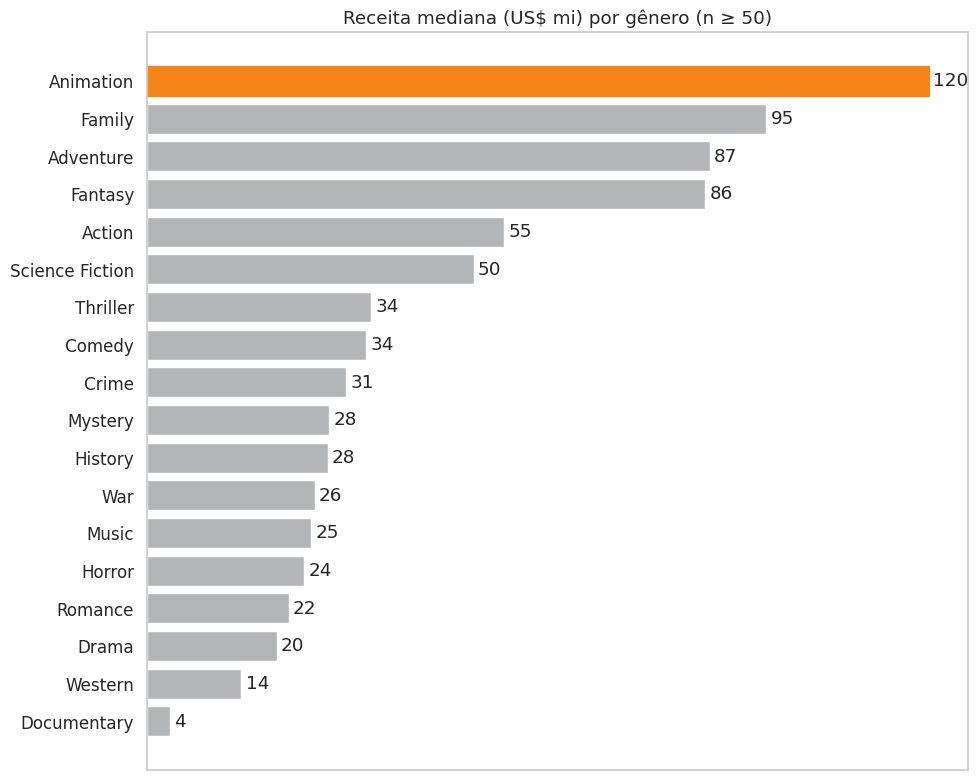

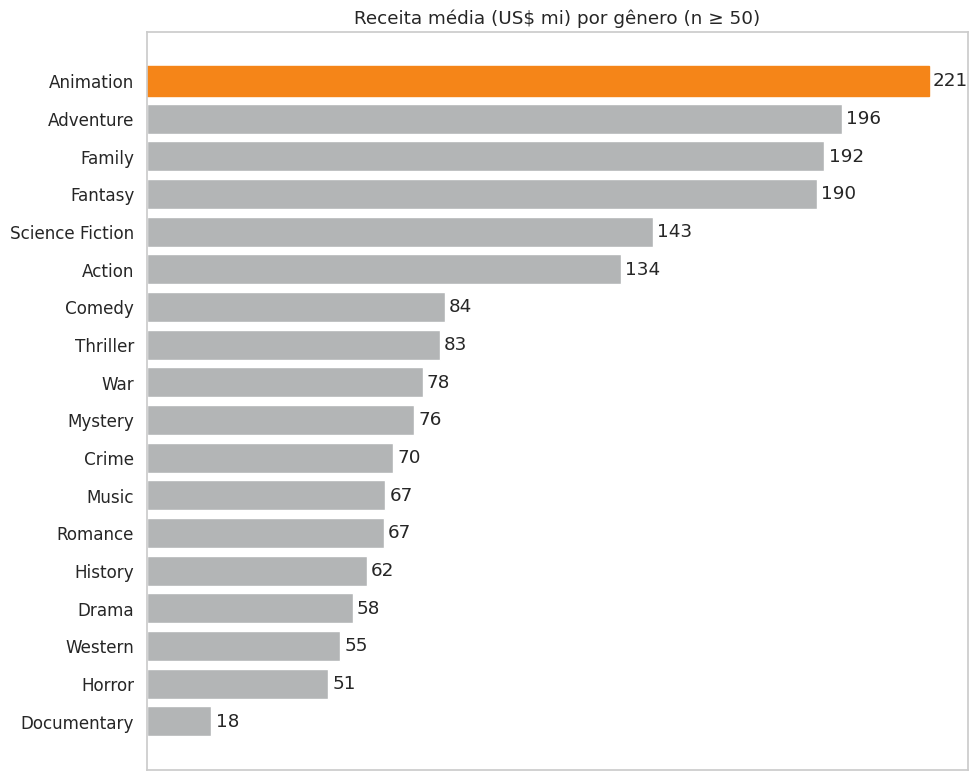

In [53]:
# Receita (mediana) por gênero
rev_sorted = genre_stats.sort_values('med_revenue', ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
bars = ax.barh(rev_sorted['genres_list'], rev_sorted['med_revenue'], color=NEUTRAL)
# destaque no topo
bars[0].set_color(HILIGHT)
# rótulos diretos nas barras
ax.bar_label(bars, fmt="%.0f", padding=3)
# ajustes visuais
ax.invert_yaxis()
ax.set_title('Receita mediana (US$ mi) por gênero (n ≥ 50)')
ax.set_xlabel('US$ milhões')
ax.xaxis.set_visible(False) 
ax.set_facecolor("white")    
ax.grid(False)               
plt.tight_layout()
plt.show()


# Receita (média) por gênero
rev_sorted = genre_stats.sort_values('mean_revenue', ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
bars = ax.barh(rev_sorted['genres_list'], rev_sorted['mean_revenue'], color=NEUTRAL)
# destaque no topo
bars[0].set_color(HILIGHT)
# rótulos diretos nas barras
ax.bar_label(bars, fmt="%.0f", padding=3)
# ajustes visuais
ax.invert_yaxis()
ax.set_title('Receita média (US$ mi) por gênero (n ≥ 50)')
ax.set_xlabel('US$ milhões')
ax.xaxis.set_visible(False) 
ax.set_facecolor("white")    
ax.grid(False)               
plt.tight_layout()
plt.show()

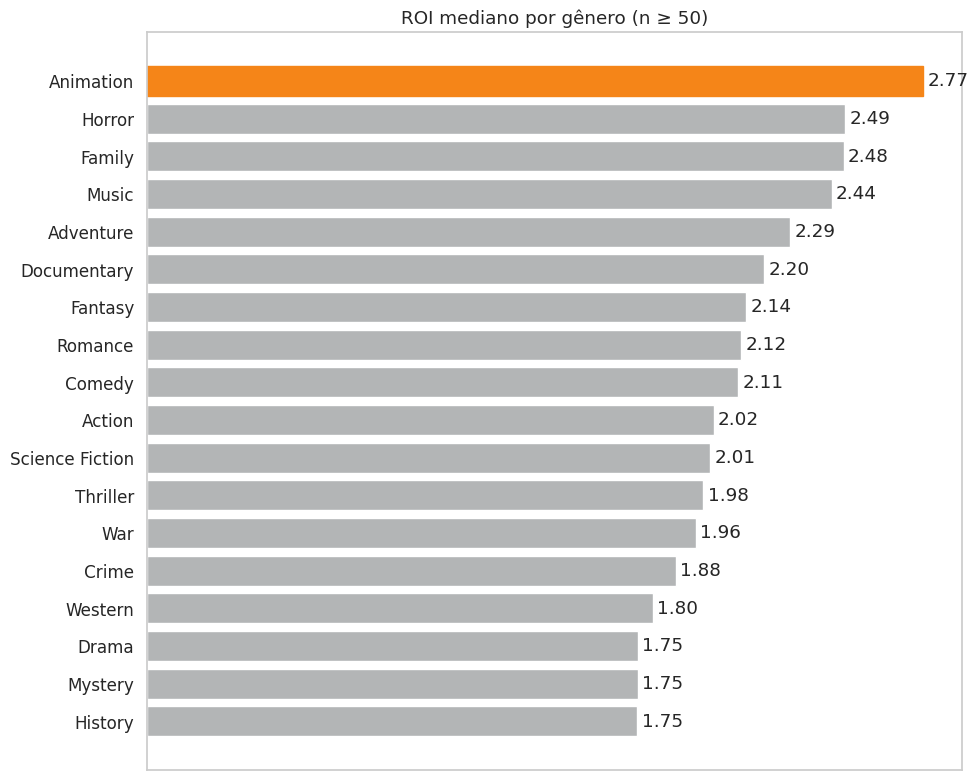

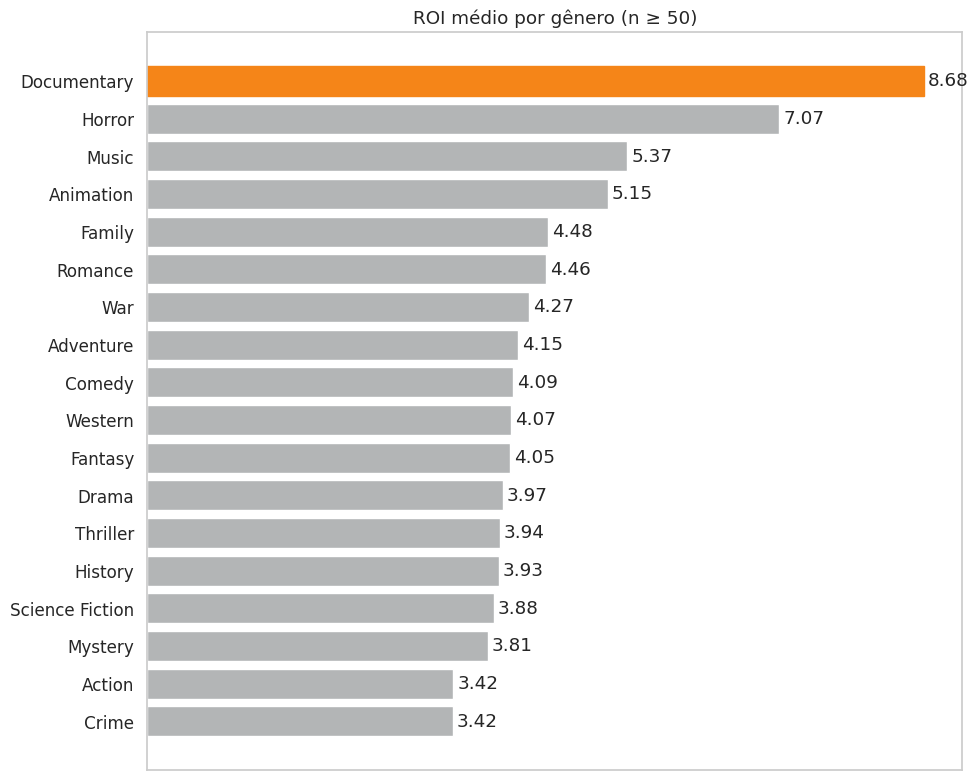

In [54]:
# ROI (mediano) por gênero
roi_sorted = genre_stats.sort_values('med_roi', ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
bars = ax.barh(roi_sorted['genres_list'], roi_sorted['med_roi'], color=NEUTRAL)
# destaque no topo
bars[0].set_color(HILIGHT)
# rótulos diretos nas barras
ax.bar_label(bars, fmt="%.2f", padding=3)
# ajustes visuais
ax.invert_yaxis()
ax.set_title('ROI mediano por gênero (n ≥ 50)')
ax.set_xlabel('Receita / Orçamento')
ax.xaxis.set_visible(False)  
ax.set_facecolor("white")     
ax.grid(False)               
plt.tight_layout()
plt.show()


# ROI (médio) por gênero – mesmo padrão
# ROI (mediano) por gênero
roi_sorted = genre_stats.sort_values('mean_roi', ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
bars = ax.barh(roi_sorted['genres_list'], roi_sorted['mean_roi'], color=NEUTRAL)
# destaque no topo
bars[0].set_color(HILIGHT)
# rótulos diretos nas barras
ax.bar_label(bars, fmt="%.2f", padding=3)
# ajustes visuais
ax.invert_yaxis()
ax.set_title('ROI médio por gênero (n ≥ 50)')
ax.set_xlabel('Receita / Orçamento')
ax.xaxis.set_visible(False)  
ax.set_facecolor("white")    
ax.grid(False)               
plt.tight_layout()
plt.show()

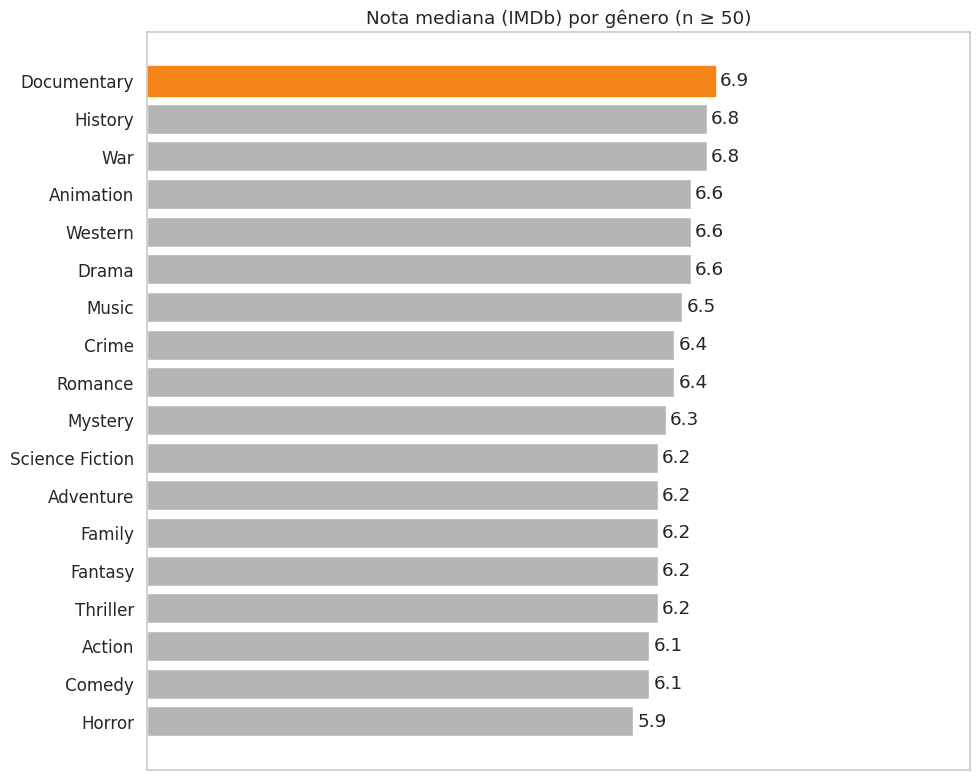

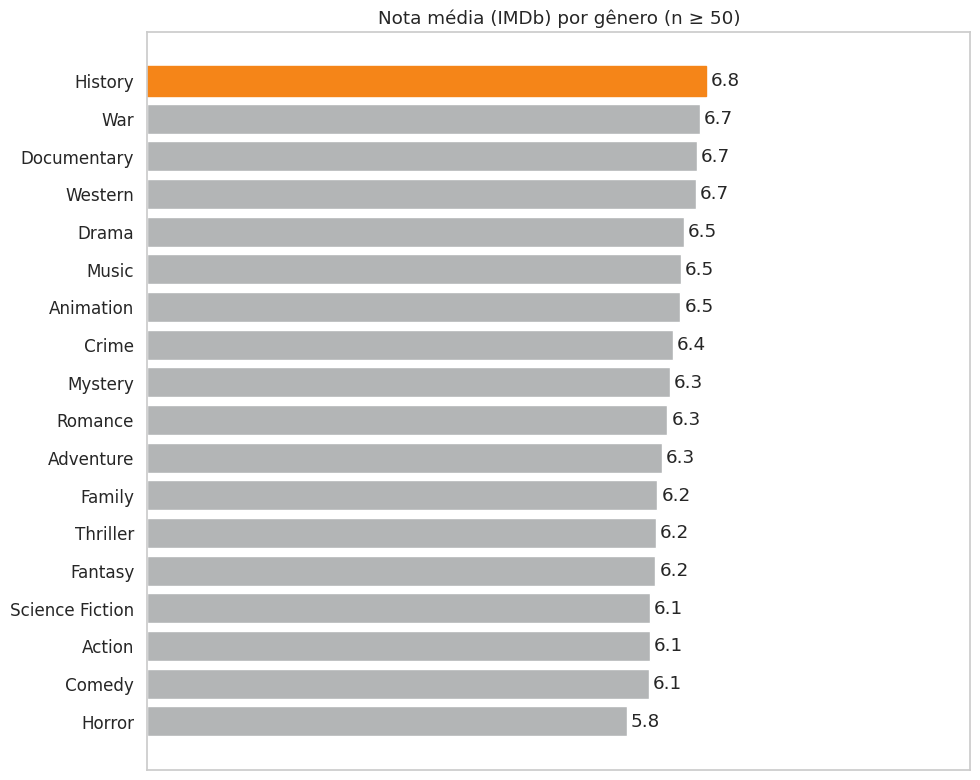

In [55]:
# Nota (mediana) por gênero
vote_sorted = genre_stats.sort_values('med_vote', ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
bars = ax.barh(vote_sorted['genres_list'], vote_sorted['med_vote'], color=NEUTRAL)

# destaque no topo
bars[0].set_color(HILIGHT)

# labels direto nas barras
ax.bar_label(bars, fmt="%.1f", padding=3)

# ajustes visuais
ax.invert_yaxis()
ax.set_title('Nota mediana (IMDb) por gênero (n ≥ 50)')
ax.set_xlabel('Nota IMDb (0–10)')
ax.set_xlim(0, 10) 
ax.xaxis.set_visible(False)  
ax.set_facecolor("white")   
ax.grid(False)              
plt.tight_layout()
plt.show()

# Nota (média) por gênero
vote_sorted = genre_stats.sort_values('mean_vote', ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
bars = ax.barh(vote_sorted['genres_list'], vote_sorted['mean_vote'], color=NEUTRAL)

# destaque no topo
bars[0].set_color(HILIGHT)

# labels direto nas barras
ax.bar_label(bars, fmt="%.1f", padding=3)

# ajustes visuais
ax.invert_yaxis()
ax.set_title('Nota média (IMDb) por gênero (n ≥ 50)')
ax.set_xlabel('Nota IMDb (0–10)')
ax.set_xlim(0, 10) 
ax.xaxis.set_visible(False)  
ax.set_facecolor("white")   
ax.grid(False)              
plt.tight_layout()
plt.show()

## K2 — 6.6 — H6. Existe associação entre diretor/elenco e sucesso de bilheteria (receita)? Essa influência permanece quando controlamos por ROI?
R: Sim, mas de formas diferentes. Os diretores são determinantes para a consistência da bilheteira (receita absoluta), enquanto alguns atores impulsionam tanto bilheteira quanto ROI (retorno proporcional) dependendo do tipo de projeto e orçamento. Para decisões, se o objetivo é volume de faturamento, nomes de franquias fazem sentido; se é rentabilidade, diretores/atores de projetos médios/baixos podem ser mais atrativos.

**Principais Insights:**
  
**Receita (mediana) por Diretor e Ator:**
* Diretores: Kyle Balda, David Yates e Peter Jackson dominam em receita mediana (acima de US$ 800M). São nomes associados a grandes franquias (Harry Potter, O Senhor dos Anéis, animações da Illumination).
* Atores: Daniel Radcliffe, Chris Pratt e Robert Downey Jr. têm receitas medianas acima de US$ 400M, também vinculados a franquias globais (Harry Potter, Marvel, Jurassic).
* Insight: tanto no eixo diretores quanto no elenco, **as franquias e animações de apelo global são os motores da bilheteira**.

**ROI (mediano) por Diretor e Ator:**
* Diretores: George Lucas (7.78x) e Kyle Balda (12.75x) são destaques, embora puxados por franquias icônicas. Outros como Pete Docter e James Gunn mantêm ROI sólido (~4–5x).
* Atores: Mark Hamill (29.9x), Dakota Johnson (~6.9x), Chris Pratt (~6.2x) e Jennifer Lawrence (~6.2x) combinam ROI alto com bilheteira relevante.
* Insight: **atores jovens ou vinculados a gêneros de médio orçamento (Thriller, Romance adulto, franquias Sci-Fi) entregam eficiência de capital maior do que blockbusters ultracaros**.

**Orçamento (mediano):**
* Diretores como Peter Jackson e David Yates trabalham com orçamentos medianos a elevados (US$ 180M–190M).
* Já atores como Dakota Johnson e Kristen Stewart aparecem em projetos de médio custo (US$ 40M–60M), que sustentam ROI mais alto.
* **Insight: o ROI melhor aparece quando atores de apelo de público são usados em projetos menores, sem inflar custos.**

**Conclusões de Negócio:**
* **Se o objetivo é bilheteira:** Apostar em diretores consagrados de franquias (Yates, Jackson, Balda) e atores-âncora (Radcliffe, Pratt, Downey Jr.) garante alto volume de receita.
* **Se o objetivo é ROI:** Melhor explorar atores de mid-budget como Dakota Johnson, Kristen Stewart e até veteranos com histórico em Sci-Fi/Fantasy (Mark Hamill), que entregam proporcionalmente mais retorno.
* **Se o objetivo é diversificação:** Balancear o portfólio da PProductions com 1 projeto “trator de bilheteira” (blockbuster familiar ou franquia, diretor renomado, elenco global). 1–2 projetos mid-budget (Thriller/Crime/Romance) com atores que historicamente entregam ROI alto em custos moderados.

**Para a PProductions: A recomendação inicial é não apostar só em blockbusters caríssimos. O caminho estratégico é, usar nomes fortes em franquias (segurança de receita). Mas diversificar com mid-budget de apelo crítico e ROI alto, alavancando atores com histórico de eficiência (Dakota Johnson, Kristen Stewart, Jennifer Lawrence em dramas ou thrillers).**

In [56]:
# Certifica-se de que as colunas são numéricas
temp_df = df[["director", "revenue", "budget"]].copy()
temp_df["revenue"] = pd.to_numeric(temp_df["revenue"], errors="coerce")
temp_df["budget"] = pd.to_numeric(temp_df["budget"], errors="coerce")

# Remove filmes com valores nulos para revenue ou budget
temp_df = temp_df.dropna(subset=['revenue', 'budget'])

# Calcula o ROI (ROI = receita / orçamento)
# Adiciona 1 aos orçamentos zero para evitar divisão por zero
temp_df["budget_clean"] = temp_df["budget"].apply(lambda x: x if x > 0 else 1)
temp_df["roi"] = temp_df["revenue"] / temp_df["budget_clean"]

# Top 10 Diretores por Receita Mediana
top10_diretores_roi = (temp_df.groupby("director").agg(n_filmes=("revenue", "size"), 
    med_rev=("revenue", "median"),
    total_rev=("revenue", "sum"),
    total_budget=("budget", "sum"),
    med_budget=("budget", "median"),
    med_roi=("roi", "median")).query("n_filmes >= 3").sort_values("med_rev", ascending=False).head(10))

# ROI total (agregado): receita total / orçamento total
top10_diretores_roi["total_roi"] = top10_diretores_roi["total_rev"] / top10_diretores_roi["total_budget"]

# Exibe o resultado 
print("Top 10 Diretores por Receita Mediana:")
top10_diretores_roi.style.format({
    'total_rev': '${:,.0f}',
    'med_rev': '${:,.0f}',
    'total_budget': '${:,.0f}',
    'med_budget': '${:,.0f}',
    'total_roi': '${:,.2f}',
    'med_roi': '${:.2f}'
})

Top 10 Diretores por Receita Mediana:


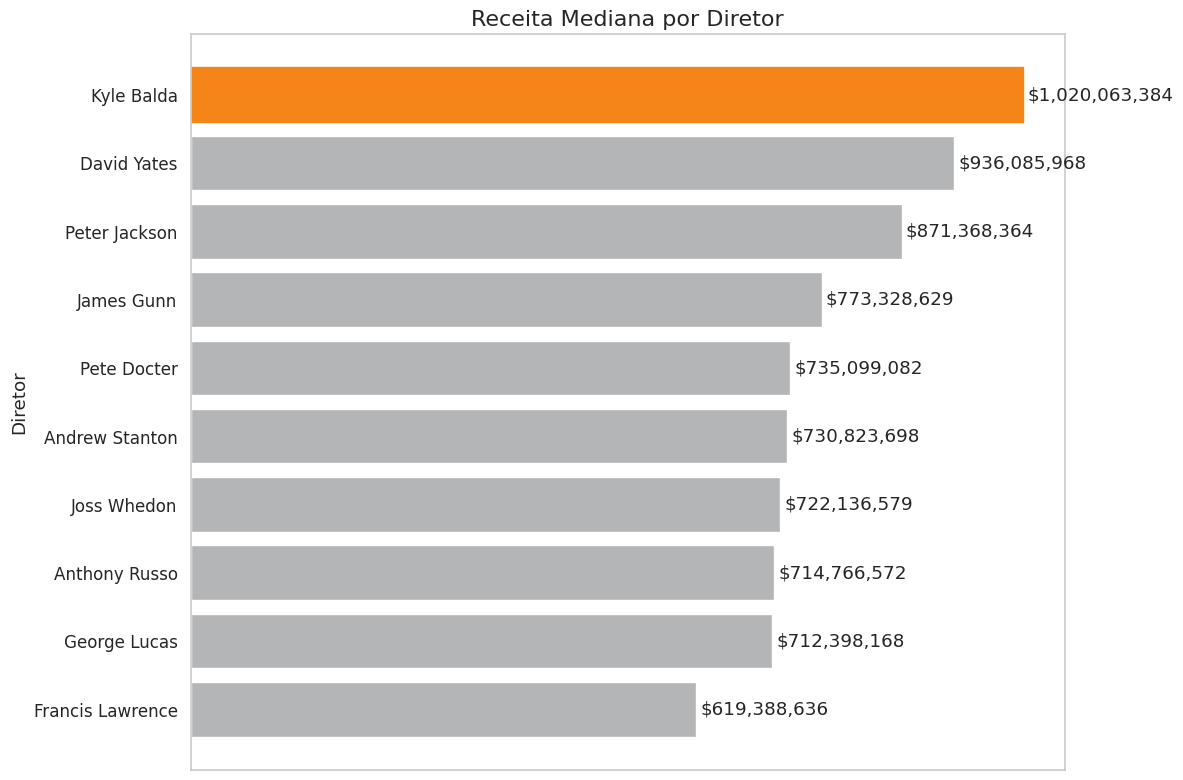

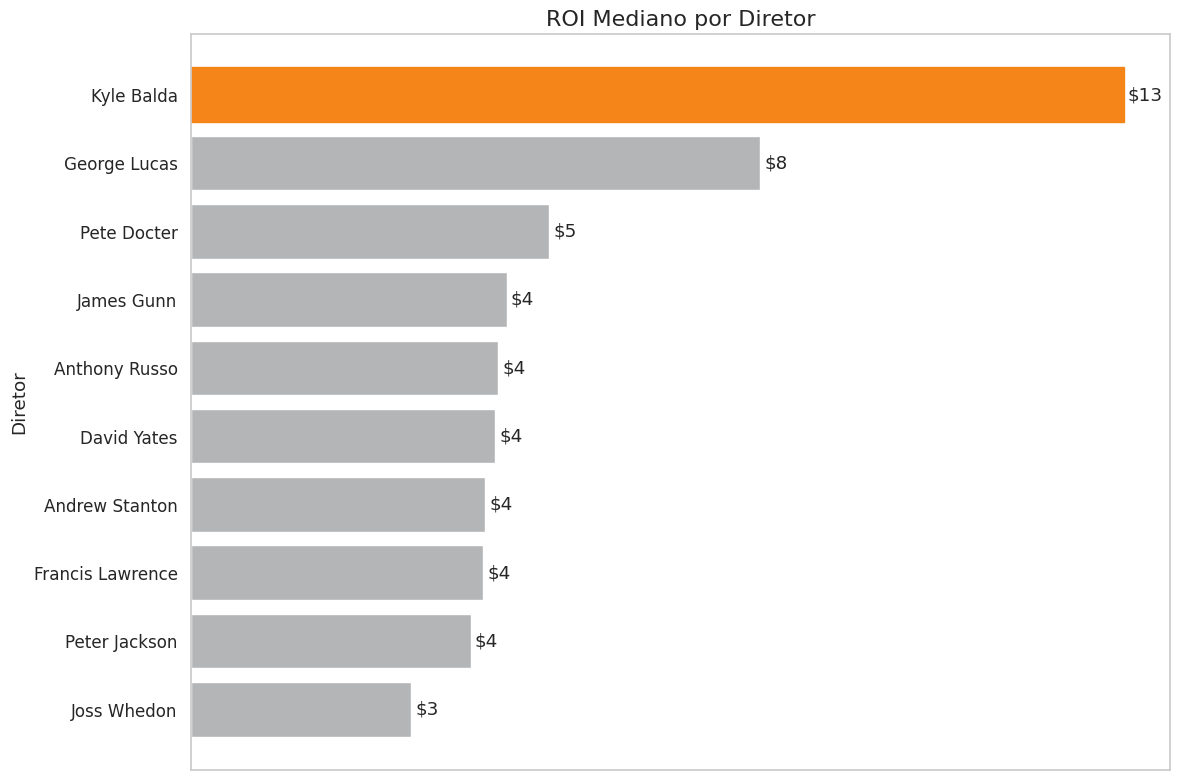

In [57]:
# Top 10 diretores Receita
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(top10_diretores_roi.index, top10_diretores_roi['med_rev'], color=NEUTRAL)
bars[0].set_color(HILIGHT)
# Rótulos com o valor da receita formatado como moeda
ax.bar_label(bars, fmt=lambda x: f"${x:,.0f}", padding=3)
# Ajustes visuais
ax.invert_yaxis()
ax.set_title('Receita Mediana por Diretor', fontsize=16)
ax.set_xlabel('Receita Mediana (USD)')
ax.set_ylabel('Diretor')
ax.set_facecolor("white")
ax.grid(False)
ax.xaxis.set_visible(False)
plt.tight_layout()
plt.show()


# Top 10 diretores ROI
# Prepara os dados para o gráfico, ordenando-os por ROI para a visualização
plot_df = top10_diretores_roi.sort_values(by='med_roi', ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(plot_df.index, plot_df['med_roi'], color=NEUTRAL)
bars[0].set_color(HILIGHT)
# Rótulos com o valor da receita formatado como moeda
ax.bar_label(bars, fmt=lambda x: f"${x:,.0f}", padding=3)
# Ajustes visuais
ax.invert_yaxis()
ax.set_title('ROI Mediano por Diretor', fontsize=16)
ax.set_xlabel('ROI Mediano (USD)')
ax.set_ylabel('Diretor')
ax.set_facecolor("white")
ax.grid(False)
ax.xaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [58]:
# Certifica-se de que as colunas são numéricas
temp_df = df[["star1", "revenue", "budget"]].copy()
temp_df["revenue"] = pd.to_numeric(temp_df["revenue"], errors="coerce")
temp_df["budget"] = pd.to_numeric(temp_df["budget"], errors="coerce")

# Remove filmes com valores nulos para revenue ou budget
temp_df = temp_df.dropna(subset=['revenue', 'budget'])

# Calcula o ROI (ROI = receita / orçamento)
# Adiciona 1 aos orçamentos zero para evitar divisão por zero
temp_df["budget_clean"] = temp_df["budget"].apply(lambda x: x if x > 0 else 1)
temp_df["roi"] = temp_df["revenue"] / temp_df["budget_clean"]

# Top 10 atores por Receita Mediana
top10_atores_roi = (temp_df.groupby("star1").agg(n_filmes=("revenue", "size"), 
    med_rev=("revenue", "median"),
    total_rev=("revenue", "sum"),
    total_budget=("budget", "sum"),
    med_budget=("budget", "median"),
    med_roi=("roi", "median")).query("n_filmes >= 3").sort_values("med_rev", ascending=False).head(10))

# ROI: receita total / orçamento total
top10_atores_roi["total_roi"] = top10_atores_roi["total_rev"] / top10_atores_roi["total_budget"]

# Exibe o resultado 
print("Top 10 atores principais por Receita Mediana:")
top10_atores_roi.style.format({
    'total_rev': '${:,.0f}',
    'med_rev': '${:,.0f}',
    'total_budget': '${:,.0f}',
    'med_budget': '${:,.0f}',
    'total_roi': '${:,.2f}',
    'med_roi': '${:.2f}'
})

Top 10 atores principais por Receita Mediana:


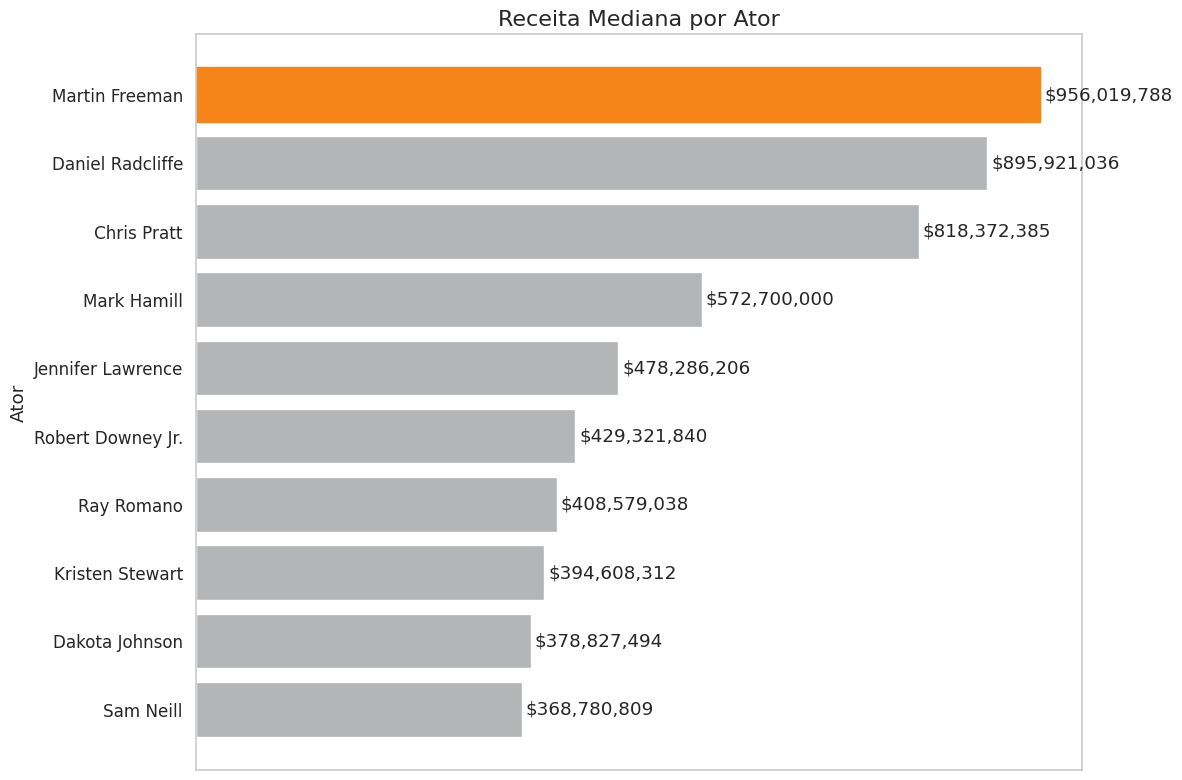

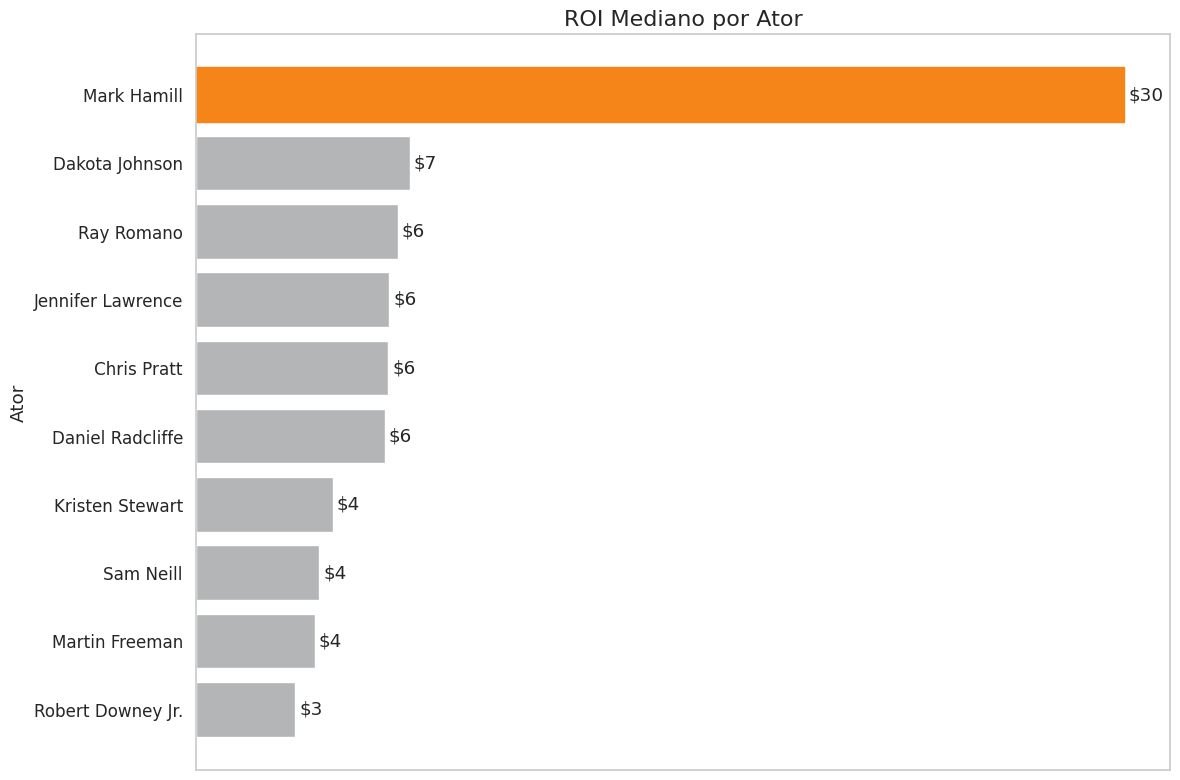

In [59]:
# Top 10 atores Receita
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(top10_atores_roi.index, top10_atores_roi['med_rev'], color=NEUTRAL)
bars[0].set_color(HILIGHT)
# Rótulos com o valor da receita formatado como moeda
ax.bar_label(bars, fmt=lambda x: f"${x:,.0f}", padding=3)
# Ajustes visuais
ax.invert_yaxis()
ax.set_title('Receita Mediana por Ator', fontsize=16)
ax.set_xlabel('Receita Mediana (USD)')
ax.set_ylabel('Ator')
ax.set_facecolor("white")
ax.grid(False)
ax.xaxis.set_visible(False)
plt.tight_layout()
plt.show()


# Top 10 atores ROI mediano
# Prepara os dados para o gráfico, ordenando-os por ROI para a visualização
plot_df = top10_atores_roi.sort_values(by='med_roi', ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(plot_df.index, plot_df['med_roi'], color=NEUTRAL)
bars[0].set_color(HILIGHT)
# Rótulos com o valor da receita formatado como moeda
ax.bar_label(bars, fmt=lambda x: f"${x:,.0f}", padding=3)
# Ajustes visuais
ax.invert_yaxis()
ax.set_title('ROI Mediano por Ator', fontsize=16)
ax.set_xlabel('ROI Mediano (USD)')
ax.set_ylabel('Ator')
ax.set_facecolor("white")
ax.grid(False)
ax.xaxis.set_visible(False)
plt.tight_layout()
plt.show()

## K2 — 6.7 — H7. Qual filme recomendaria a alguém que você não conhece?
R: Sem preferências do usuário, recomendo algo robusto, baseado em nota alta (>7.5), muitos votos (percentil 95) e, popularidade (percentil 95). Esse filtro garante que os títulos sugeridos tenham boa recepção crítica, amplo reconhecimento e grande apelo público, como os filmes: 1-'dilwale dulhania le jayenge'; 2-'the shawshank redemption' e 3-'the godfather', que parecem ser boas escolhas.

**Principais Insights:**
  
**Filmes Recomendados:**
* **Dilwale Dulhania Le Jayenge (1995)** – Nota 9.1, clássico indiano de Romance/Drama/Comedy, prova de que filmes fora do eixo Hollywood também têm alto reconhecimento e impacto cultural.
* **The Shawshank Redemption (1994)** – Nota 8.5, amplamente considerado o melhor drama criminal já feito.
* **The Godfather (1972)** – Nota 8.5, ícone do cinema com impacto crítico e cultural enorme.
* **君の名は (Your Name, 2016)** – Nota 8.5, animação japonesa que combina romance e fantasia, popular globalmente.
* **The Dark Knight (2008)** – Nota 8.3, blockbuster que alia sucesso de bilheteria com aclamação crítica.

**Padrões Encontrados:**
* Diversidade geográfica e cultural: Índia, Japão e EUA aparecem na lista → sinal de que a metodologia não está enviesada apenas para Hollywood.
* *Equilíbrio entre gêneros: Drama/Crime (clássicos sérios), Romance/Animation (emocional e visualmente impactante), e Action/Thriller (entretenimento popular).
* Popularidade recente: The Dark Knight, por exemplo, une alto número de votos (12k+) com popularidade enorme, mostrando relevância contínua.

**Conclusões de Negócio:**
Para a PProductions: esse tipo de filtro é uma base para sistemas de recomendação genéricos, útil em plataformas de streaming ou na comunicação de marketing (listas de “filmes imperdíveis” que agradam públicos amplos).
* Relevância:
  * Se o objetivo for máxima aceitação geral, apostar em títulos do estilo The Shawshank Redemption ou The Dark Knight é estratégico.
  * Se a intenção for expandir público, recomendações como Your Name e Dilwale Dulhania Le Jayenge mostram o poder de títulos internacionais bem avaliados.
* Em resumo: para alguém que não conhecemos a preferência, recomenda-se filmes que combinam alta nota crítica, ampla popularidade e número expressivo de votos. Isso garante equilíbrio entre qualidade percebida e apelo popular, reduzindo o risco de rejeição.

In [60]:
# Defino os critérios para uma recomendação sólida
# Um filme deve ter uma nota acima de 7.5
filtro_nota = 7.5

# Um número significativo de votos para garantir que não seja um filme obscuro
limite_votos = df['vote_count'].quantile(0.95)

# E uma popularidade alta (acima do 95º percentil)
limite_popularidade = df['popularity'].quantile(0.95)

# Filtro o DataFrame para encontrar os filmes que se encaixam nos critérios
candidatos = df[(df['vote_average'] >= filtro_nota) &
                (df['vote_count'] >= limite_votos) &
                (df['popularity'] >= limite_popularidade)]

# Ordeno os candidatos pela nota e pelo número de votos para desempate
recomendacoes = candidatos.sort_values(by=['vote_average', 'vote_count'], ascending=False)

# Seleciona as top 5 recomendações
top_5_filmes = recomendacoes[['original_title_norm', 'genres_list', 'vote_average', 'vote_count', 'popularity']].head(5)

print("Recomendações de filmes para alguém que você não conhece:")
top_5_filmes

Recomendações de filmes para alguém que você não conhece:


original_title_norm                               genres_list  \
1634  dilwale dulhania le jayenge            ['Comedy', 'Drama', 'Romance']   
19       the shawshank redemption                        ['Drama', 'Crime']   
61                  the godfather                        ['Drama', 'Crime']   
1087                         君の名は         ['Romance', 'Animation', 'Drama']   
1                 the dark knight  ['Drama', 'Action', 'Crime', 'Thriller']   

      vote_average  vote_count  popularity  
1634          9.10      661.00       34.46  
19            8.50     8358.00       51.65  
61            8.50     6024.00       41.11  
1087          8.50     1030.00       34.46  
1             8.30    12269.00      123.17

## K2 — 6.8 — H8. Ano de lançamento dos filmes influencia na receita?
R: Sim, mas de formas diferentes para receita e engajamento (número de votos). Por exemplo, a receita atingiu pico nos anos 2000, mas caiu na década seguinte (2010), já o engajamento (votos) continua crescendo, mostrando maior participação do público. Para a PProductions, significa que a janela de cinema sozinha já não garante sucesso, é preciso equilibrar blockbuster com estratégias digitais.

**Principais Insights:**
  
**Receita Mediana por meia Década:**
* De forma geral, a receita cresce até meados dos anos 2000, atingindo seu pico (~29M em 2000).
* Após 2010, a receita mediana cai (~12M), o que pode refletir:
  * Mudança no consumo (streaming vs. cinema).
  * Aumento na quantidade de filmes lançados → dilui bilheteria média.
  * Concorrência mais acirrada no mercado global.
* Nos anos 70–90, vemos um crescimento contínuo, marcando a era de blockbusters (Star Wars, Indiana Jones, etc.).
* Insight: Filmes recentes ainda arrecadam bem, mas a mediana sugere que blockbusters dominavam mais fortemente os anos 80–2000 do que a década de 2010.

**Votos (Engajamento) por meia Década:**
* Crescente e consistente: de menos de 10 votos mediana nos anos 80 para 15+ nos anos 2010.
* Isso não significa que os filmes recentes são mais bem avaliados, mas sim que: 
  * A base de usuários do IMDb cresceu muito (internet popularizada).
  * Filmes novos são mais discutidos e avaliados, mesmo que não sejam os mais lucrativos.
* Insight: O engajamento (avaliações) tende a crescer com o tempo, refletindo maior acessibilidade e participação do público online.

**Tamanho da Amostra (n):**
* A quantidade de filmes catalogados cresce exponencialmente:
  * < 1k filmes por década até 1950.
  * 8k+ filmes nos anos 2010.
* Insight: isso reforça que o mercado se expandiu (produção mais barata, democratização global do cinema).

**Conclusões de Negócio:**
Para a PProductions:
* Receita absoluta – os anos 80–2000 mostram o auge dos blockbusters, mas hoje a receita mediana caiu. É preciso diferenciar entre filmes-evento (ainda muito lucrativos, como franquias da Marvel) e a maioria dos lançamentos (que arrecadam pouco).
* Engajamento – filmes recentes têm mais visibilidade e votos. Investir em lançamentos atuais garante mais “buzz” e relevância cultural, mesmo se a receita mediana for menor.
* Estratégia – o estúdio deve apostar em grandes lançamentos planejados (evento cinematográfico) para sustentar bilheteria, mas também aproveitar a long tail digital (streaming e catálogo), que é onde os filmes medianos encontram público hoje.

In [61]:
temp_df = df.copy()
for c in ["revenue","vote_count","year"]:
    temp_df[c] = pd.to_numeric(temp_df[c], errors="coerce")
temp_df = temp_df.dropna(subset=["year"])

temp_df["decade"] = (temp_df["year"].astype(int)//10)*10
dec = (temp_df.groupby("decade")
         .agg(med_rev=("revenue","median"),
              med_votes=("vote_count","median"),
              n=("revenue","size"))
         .reset_index()
         .sort_values("decade"))

display(dec.tail(20))

decade     med_rev  med_votes      n
0     1870         NaN      22.00      2
1     1880         NaN      17.50      4
2     1890         NaN       7.00     75
3     1900         NaN       6.00     87
4     1910  8000000.00       4.00    176
5     1920   704000.00       4.00    431
6     1930  2597000.00       4.00   1315
7     1940  5519000.00       5.00   1493
8     1950  7000000.00       6.00   2079
9     1960 11000000.00       7.00   2621
10    1970 24000000.00       6.00   3471
11    1980 14257950.00      10.00   3928
12    1990 16670028.50      11.00   5671
13    2000 24914822.00      11.00  11186
14    2010 14347764.50      14.00  12782
15    2020         NaN      58.00      1

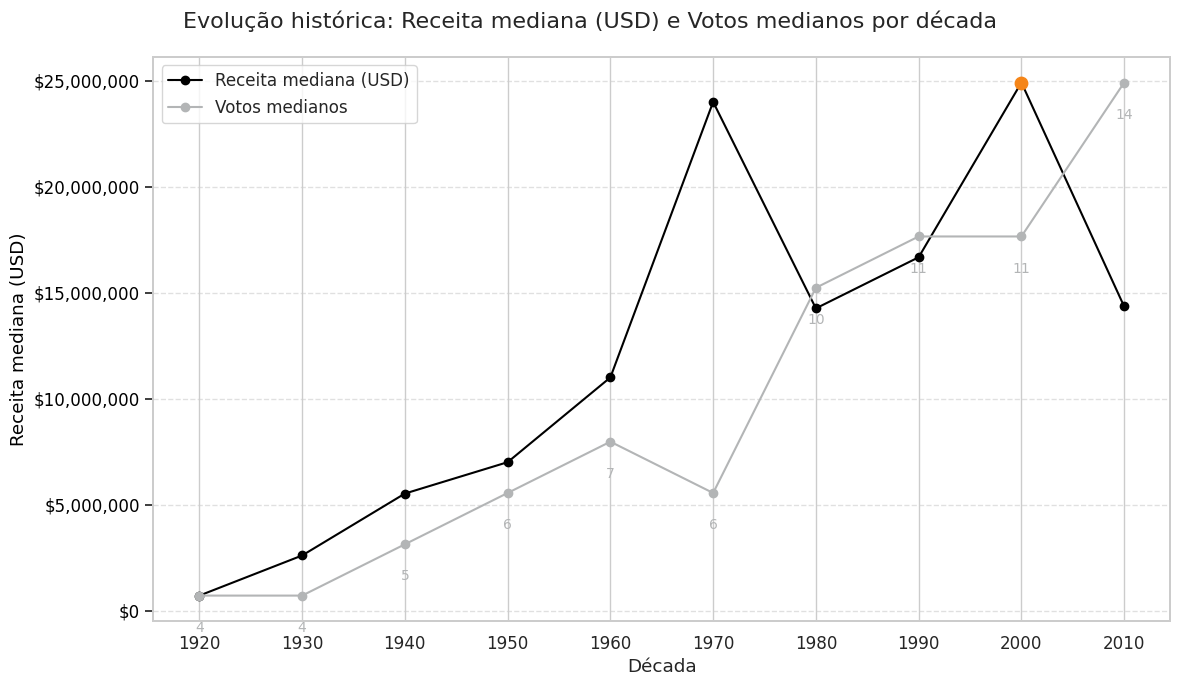

In [62]:
# Filtra período (1910 a 2019) e prepara séries
dec_f = dec.query("decade >= 1920 and decade < 2020").copy()
x = dec_f["decade"].astype(int)
y_rev = dec_f["med_rev"]
y_votes = dec_f["med_votes"]

# Localiza o pico de receita para destacar
i_max = y_rev.idxmax()
x_max, y_max = int(dec.loc[i_max, "decade"]), float(dec.loc[i_max, "med_rev"])

fig, ax1 = plt.subplots(figsize=(12, 7))

# Linha de RECEITA (eixo da esquerda)
l1, = ax1.plot(x, y_rev, marker="o", linestyle="-", color='black', label="Receita mediana (USD)")
# Destaque no maior ponto
ax1.scatter([x_max], [y_max], s=80, color=HILIGHT, zorder=3)
ax1.set_xticks(range(1920, 2020+1, 10))

# Eixo Y (esquerdo) em USD
ax1.ticklabel_format(style='plain', axis='y')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f'${v:,.0f}'))
ax1.set_xlabel("Década")
ax1.set_ylabel("Receita mediana (USD)", color='black')
ax1.tick_params(axis="y", labelcolor='black')

# Estética
ax1.set_facecolor("white")
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Linha de VOTOS (eixo da direita)
ax2 = ax1.twinx()
l2, = ax2.plot(x, y_votes, marker="o", linestyle="-", color=NEUTRAL, label="Votos medianos")

# Esconde ticks/labels do eixo direito
ax2.yaxis.set_visible(False)
ax2.set_ylabel("Votos medianos", color=NEUTRAL)

# Anota os valores de votos nas bolinhas a cada 10 anos
for xi, vi in zip(x, y_votes):
    if xi % 5 == 0:
        ax2.annotate(f"{int(vi)}", (xi, vi),
                     textcoords="offset points", xytext=(0, -18),
                     ha="center", va="top", fontsize=10, color=NEUTRAL)

# Legenda combinada
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

# Título e layout
fig.suptitle("Evolução histórica: Receita mediana (USD) e Votos medianos por década", fontsize=16)
plt.tight_layout()
plt.show()

## K2 — 6.9 — SUMÁRIO DAS RESPOSTAS DAS HIPÓTESES DE NEGÓCIO

In [74]:
# Cria dataframe com hipóteses
hypo_df = pd.DataFrame([
    {"H": "H1", "Status": "⚠️ parcial",            "Resumo": "Orçamento ↑ = Receita ↑; ROI não garantido."},
    {"H": "H2", "Status": "✅",                     "Resumo": "Popularidade antecipa bilheteria (bom leading indicator)."},
    {"H": "H3", "Status": "❌",                     "Resumo": "Nota IMDb ↑ ajuda longevidade/atração, mas não garante bilheteria."},
    {"H": "H4", "Status": "⚠️ fraco/indefinido",    "Resumo": "Runtime alto (>150m) com evidência não robusta sobre nota."},
    {"H": "H5", "Status": "✅ com nuances",         "Resumo": "Animation/Family/Adventure sustentam receita/consistência (alto orçamento/ROI moderado); Horror/Crime/Mystery tendem a maior ROI (mais voláteis). Escolha depende de receita × ROI × prestígio."},
    {"H": "H6", "Status": "⚠️ parcial",            "Resumo": "Diretor/Elenco ajudam receita; ROI depende do custo."},
    {"H": "H7", "Status": "✅",                     "Resumo": "Recomendação p/ desconhecido: alta nota + muitos votos (ex.: DDLJ (1995), Shawshank (1994))."},
    {"H": "H8", "Status": "✅",                     "Resumo": "Pós-2010: engajamento ↑, mediana de receita ↓ (fragmentação/streaming)."},
])


pd.set_option('display.max_colwidth', None)

styles = [
    dict(selector="table", props=[("table-layout","fixed"), ("width","100%")]),
    dict(selector="th",    props=[("text-align","left")]),
    dict(selector="td",    props=[("white-space","pre-wrap"), ("text-align","left")]),
]

display(hypo_df.style.set_table_styles(styles))

# salva CSV em reports/
PATHS.REP / "hypotheses_summary.csv",

(PosixPath('/home/emersds/repos_projetos/project_lighthouse/reports/hypotheses_summary.csv'),)

# K1 — 7.0 — DECISÕES E PRÓXIMOS PASSOS
**Próximos passos**
- Preparar features para modelagem (K03):
  * Garantir consistência em budget/revenue (remover zeros falsos, sentinelas).
  * Criar variáveis derivadas: ROI, log_budget/log_revenue, número de gêneros, dummy de idioma, etc.
  * Selecionar amostra robusta (filmes com receita >0 e budget >0).
- Salvar os principais gráficos da EDA em img/ ou reports/figures/ para inclusão nos relatórios.
- Responder as outras três perguntas de negócio (H9 - H10 - H11)